# Self-Driving Car Engineer Nanodegree


## 1. Project: **Advanced lane finding** 

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## 2. Libraries import & Constants definition

In [1]:
# Jupyter configuration: C:\Users\<USER>\.jupyter\jupyter_notebook_config.py
# c.NotebookApp.browser = u'C:/Program Files/Mozilla Firefox/firefox.exe %s'
# c.NotebookApp.notebook_dir = 'D:/workspaces'

# Remove autoclosing and add lane numbers
#from notebook.services.config import ConfigManager
#c = ConfigManager()
#c.update('notebook', {"CodeCell": {"cm_config": {"autoCloseBrackets": False, "lineNumbers": True}}})

In [2]:
import os
import glob # library for loading images from a directory
import random
#import pickle
import math
import cv2
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Video edition
from moviepy.editor import VideoFileClip
from IPython.display import HTML


In [57]:
IMAGE_CALIB_DIR = "camera_cal"
IMAGE_TEST_DIR = "test_images"
CHESS_WIDTH = 9
CHESS_HEIGHT = 6
VIDEO_PATH_PROJECT = 'project_video.mp4'
VIDEO_PATH_CHALLENGE = 'challenge_video.mp4'
VIDEO_PATH_HARDER = 'harder_challenge_video.mp4'


RUN_TEST_IMG = True
RUN_PROJECT_VIDEO = True
RUN_CHALLENGE_VIDEO = True
RUN_HARDER_VIDEO = False

In [4]:
def get_dir_rand_img(img_dir):
    
    # List all files in directory
    dir_imgs = [os.path.join(img_dir, f) for f in os.listdir(img_dir) if os.path.isfile(os.path.join(img_dir, f))]
    
    # Pick a random file
    img_path = random.choice(dir_imgs)

    return cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB), img_path

## 3. Camera calibration
Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

**Calibration preparation and algorithm explanation**
  * objectPoints are reference points in "world coordinates" that never "move" (because the reference is the pattern plan)
  * objectPoints coordinates are based on the pattern plan reference (0,0,0) point and a reference length
    * Top left corner of the chessboard is taken as reference in most tutorials
    * Reference length is "a square's side length" for the chessboard pattern
    * Z-coordinates are always 0 because the pattern is planar and the chessboard points depth do not change in the chessboard plan
  * objectPoints coordinates are put in relation to their imagePoints pixel coordinates counterpart during the camera calibration
  * cameraCalibration estimates the extrinsic ([R|t] matrix) parameters for camera motion around the static scene
  * cameraCalibration estimates the intrinsic parameters for focal length (fx, fy) and image center (cx, cy)
  * cameraCalibration tries to minimize the runs the re-projection error, that is, the total sum of squared distances between the observed feature/image points and the projected object points
  * **Note**<br/>
    * Currently, initialization of intrinsic parameters (when CV_CALIB_USE_INTRINSIC_GUESS is not set) is only implemented for planar calibration patterns (where Z-coordinates of the object points must be all zeros). 3D calibration rigs can also be used as long as initial cameraMatrix is provided.<br/>
    * So if not providing camera focal length (fx, fy) and image center (cx, cy) intrinsic parameters, you have to use a planar (Z=0) calibration pattern.<br/>
    * Link to own comment, result of digging around https://stackoverflow.com/a/63432041/685996

In [5]:
def calibrate(img_dir, chess_width, chess_height):
    # Inspired from: https://medium.com/@aliyasineser/opencv-camera-calibration-e9a48bdd1844
    # - Decided not to load the image list in a separate function not to fill RAM
    
    objpoints = []  # 3D points in real world space
    imgpoints = []  # 2D points in image plane
    image_shape = None
        
    # Iterate through each image file in the directory
    # glob reads in any image with the extension "image_dir/im_type/*"
    for file in glob.glob(os.path.join(img_dir, "*")):

        # Read in the image
        img = cv2.imread(file)
        
        # Retrieve image shape once
        if image_shape is None:
            # Assuming all images have same shape
            img_shape = img.shape[1::-1]

        # Check if the image exists / if it's been correctly read
        if not img is None:
            # Get image object points and image points
            objp, imgp = get_image_objp_imgp(img, chess_width, chess_height)
            
            # Check if corners were found
            if not objp is None:
                # Append the image points matrix
                imgpoints.append(imgp)
                # Append the corresponding objects points matrix
                objpoints.append(objp)
            else:
                print("WARNING: Could not extract chessboard from image '{}'".format(file))
    
    # All calibration images were processed, compute calibration matrix and distortion    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_shape, None, None)    

    return ret, mtx, dist, rvecs, tvecs

def get_image_objp_imgp(img, chess_width, chess_height):
    # Convert image to gray
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Find image points
    ret, corners = cv2.findChessboardCorners(gray, (chess_width, chess_height), None)

    # Check if corners were found
    if ret:
        # Image points (corners)        
        # TODO: Could refine location with cornerSubPix
        imgpoints = corners
        # Chessboard (x,y,z) list of points, which will correspond to found (pixel_x, pixel_y) image points
        # Note: z = 0
        # Create matrix
        objpoints = np.zeros((chess_width*chess_height, 3), np.float32)

        # Fill matrix with board coordinates
        objpoints[:, :2] = np.mgrid[0:chess_width, 0:chess_height].T.reshape(-1, 2)
        
        return objpoints, imgpoints
    
    return None, None

### 3.1. Calibrate camera

In [6]:
# Retrieve calibration matrix and distortion coefficients 
ret, calib_mtx, calib_dist, rvecs, tvecs = calibrate(IMAGE_CALIB_DIR, CHESS_WIDTH, CHESS_HEIGHT)
#print([ret, mtx, dist, rvecs, tvecs])

**Comment**<br/>
Calibration image 1, 4 and 5 cannot be processed because the full chess is not visible.<br/>
Tried to reduce height by one for those images specifically but still did not work.

### 3.2. Display chessboard corners

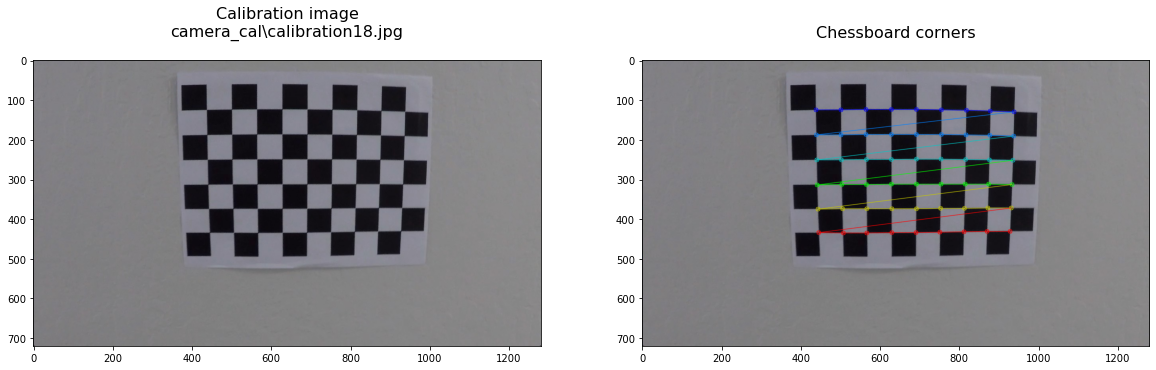

In [7]:
if RUN_TEST_IMG:   
    # Get random/specific chessboard calibration image
    img_chessboard, img_chessboard_path = get_dir_rand_img(IMAGE_CALIB_DIR)
    #img_chessboard_path = os.path.join(IMAGE_CALIB_DIR, "calibration2.jpg")
    #img_chessboard = cv2.imread(img_chessboard_path)

    # Find chessboard corners for chessboard calibration image
    ret, corners = cv2.findChessboardCorners(img_chessboard, (CHESS_WIDTH, CHESS_HEIGHT), None)

    # Check if corners were found
    if not ret:
        print("WARNING: Could not extract chessboard from image '{}'".format(img_chessboard_path))
    else:
        # Display chessboard corners over chessboard calibration image
        img_chessboard_corners = np.copy(img_chessboard)
        cv2.drawChessboardCorners(img_chessboard_corners, (CHESS_WIDTH, CHESS_HEIGHT), corners, ret)
        f, (ax11, ax12) = plt.subplots(1, 2, figsize=(20,20))
        ax11.imshow(img_chessboard)
        ax11.set_title('Calibration image\n{}\n'.format(img_chessboard_path), fontsize=16)
        ax12.imshow(img_chessboard_corners)
        ax12.set_title('Chessboard corners\n', fontsize=16)
        plt.show()

## 4. Distortion correction 
Apply a distortion correction to raw images.

### 4.1. Image selection

In [8]:
if RUN_TEST_IMG:
    # Use this image to calibrate warping
    #img_test_path = os.path.join(IMAGE_TEST_DIR, "straight_lines1.jpg")
    
    # Get random / specific test image    
    #img_test, img_test_path = get_dir_rand_img(IMAGE_TEST_DIR)
    #img_test_path = os.path.join(IMAGE_TEST_DIR, "test1.jpg")
    #img_test_path = os.path.join(IMAGE_TEST_DIR, "video_0.jpg")
    img_test_path = os.path.join(IMAGE_TEST_DIR, "error_1.jpg")

### 4.2 Undistort image

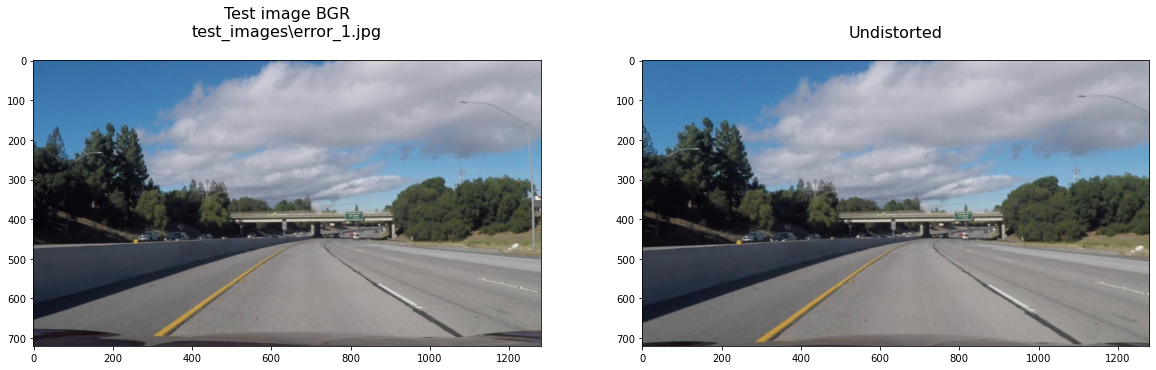

In [9]:
if RUN_TEST_IMG:    
    img_test = cv2.cvtColor(cv2.imread(img_test_path), cv2.COLOR_BGR2RGB)

    # Undistort image
    img_undistorted = cv2.undistort(img_test, calib_mtx, calib_dist, None, calib_mtx)

    # Display with CV2 example code
    #cv2.imshow('Image', img)
    # Add those 2 lines to prevent cv2 from crashing
    #cv2.waitKey(0) 
    #cv2.destroyWindow('Image')

    # Display undistorted test image
    f, (ax11, ax12) = plt.subplots(1, 2, figsize=(20,20))    
    ax11.imshow(img_test)
    ax11.set_title("Test image BGR\n{}\n".format(img_test_path), fontsize=16)
    ax12.imshow(img_undistorted)
    ax12.set_title("Undistorted\n", fontsize=16)
    plt.show()

**Comment**<br/>
You can especially notice how the bridge you pass under is straightened in "error_0.jpg" image

## 5. Image filtering
Use color transforms, gradients, etc., to create a thresholded binary image.

**Image filters and algorithm explanation**<br/>
  * Tried out warping before filtering at the begining but abandonned idea (due to issues in filtering)
  * **Gradient filterings & combining** Sobel X/Y and Magnitude/Direction filters over a grayscale image
    * Filtered out darker colors using average grayscale to prevent road reparations from being picked up
    * --> ((mag_binary & dir_binary) | (grad_x_binary & grad_y_binary)) & gray_binary
  * **Color properties filterings & combining** 
    * Gathered the idea from another projects using LAB/LUV: https://towardsdatascience.com/computer-vision-for-lane-finding-24ea77f25209
    * Final filter HLS | LUV | LAB with only HLS S (brightness), LUV L (white/brightness) and LAB B (yellow) channels filters
  * **HLS color scheme** Easier to filter shape contours, no matter their color, using lightness/saturation gradients
      * **Hue:** Degree on the color wheel from 0 to 360. 0 is red, 120 is green, 240 is blue.
      * **Saturation** Percentage value; 0% means a shade of gray and 100% is the full color.
      * **Lightness** Percentage; 0% is black, 100% is white.
  * **(CIE)LUV color scheme** Efficient at detecting white
      * See components determination there: https://en.wikipedia.org/wiki/CIELUV
  * **(CIE)LAB color scheme** Efficient at detecting yellow
      * See components determination there: https://en.wikipedia.org/wiki/CIELAB_color_space
  * **Final combination** Gradient | Color

### 5.1. Global pre-processing

In [10]:
def gaussian_blur(img, ksize=3):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (ksize, ksize), 0)

# TODO: Add average saturation from traffic light detection
def avg_saturation(img_hls):
    
    # Add up all the pixel values in the S channel
    sum_s = np.sum(img_hls[:,:,2])
    
    area = len(img_hls)*len(img_hls[1])
    
    return sum_v/area

def get_lower_s(avg_s):    
    # Got a hint on using average saturation from https://stackoverflow.com/ to have a dynamic lower saturation
    # just over average saturation to eliminate most image "normal" pixels
    lower_s_ratio = 1.25

    return int(min(avg_s * lower_s_ratio, 255))

#### 5.1.1 Compute pre-processing

In [11]:
# Pipeline parameters
ksize=3 # Kernel size for all kernel filters

#### 5.1.2 Display pre-processing

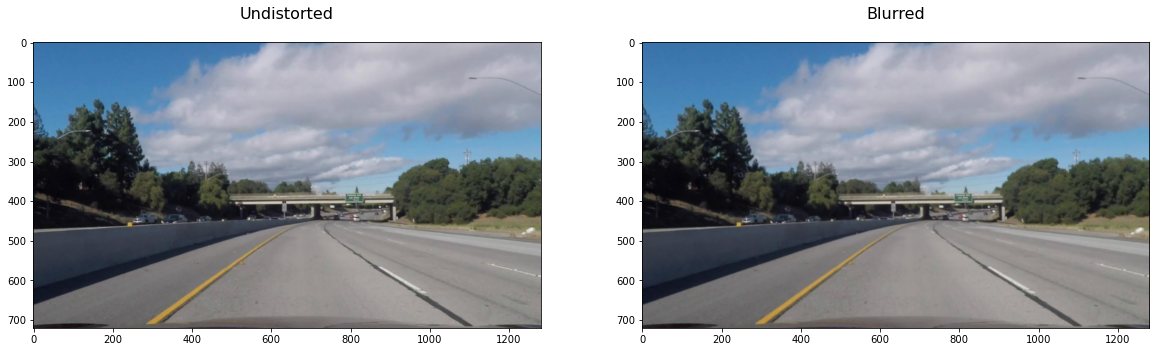

In [12]:
if RUN_TEST_IMG:
    # Apply gaussian blur
    img_blurred = gaussian_blur(img_undistorted, ksize)

    f, (ax11, ax21) = plt.subplots(1, 2, figsize=(20, 20))

    ax11.set_title("Undistorted\n", fontsize=16)
    ax11.imshow(img_undistorted)
    ax21.set_title("Blurred\n", fontsize=16)
    ax21.imshow(img_blurred)

    plt.show()

### 5.2. Gradient filters
Updated directional threshold from 0.7,1.3 to -0.3,0.3 since we warped to bird's eye view (0=vertical line, from -pi/2 to pi/2)

In [13]:
def gradient_thresh_combine(img, ksize=3, abs_thresh_x=(0, 255), abs_thresh_y=(0, 255), mag_thresh=(0, 255), dir_thresh=(0, np.pi/2)):
    # Transform BGR image to grayscale
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Get the results of each gradient thresholds
    grad_x_binary = abs_sobel_thresh(img_gray, orient='x', ksize=ksize, abs_thresh=abs_thresh_x)
    grad_y_binary = abs_sobel_thresh(img_gray, orient='y', ksize=ksize, abs_thresh=abs_thresh_y)
    mag_binary = mag_threshold(img_gray, ksize=ksize, mag_thresh=mag_thresh)
    dir_binary = dir_threshold(img_gray, ksize=ksize, dir_thresh=dir_thresh)
    
    # Apply a black gray filter
    gray_binary = avg_grayness_filter(img_gray)
    
    # Combine the gradient thresholds filters together
    combined_gradient_thresh = np.zeros_like(img_gray)    
    combined_gradient_thresh[(((mag_binary == 1) & (dir_binary == 1)) | ((grad_x_binary == 1) & (grad_y_binary == 1))) & (gray_binary == 1)] = 1
    
    return combined_gradient_thresh

def abs_sobel_thresh(img_gray, orient='x', ksize=3, abs_thresh=(0, 255)):
    # Calculate directional gradient
    if orient == 'x':
        sobel = cv2.Sobel(img_gray, cv2.CV_64F, 1, 0, ksize=ksize)
    else:
        sobel = cv2.Sobel(img_gray, cv2.CV_64F, 0, 1, ksize=ksize)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))

    # Apply threshold
    grad_binary = np.zeros_like(img_gray)
    grad_binary[(scaled_sobel >= abs_thresh[0]) & (scaled_sobel <= abs_thresh[1])] = 1
    return grad_binary

def mag_threshold(img_gray, ksize=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    sobel_x = cv2.Sobel(img_gray, cv2.CV_64F, 1, 0, ksize=ksize)
    sobel_y = cv2.Sobel(img_gray, cv2.CV_64F, 0, 1, ksize=ksize)
    abs_sobel_x = np.absolute(sobel_x)
    abs_sobel_y = np.absolute(sobel_y)
    abs_sobel = np.sqrt((abs_sobel_x**2 + abs_sobel_y**2))
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))

    # Apply threshold
    mag_binary = np.zeros_like(img_gray)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    return mag_binary

def dir_threshold(img_gray, ksize=3, dir_thresh=(0, np.pi/2)):
    # Calculate gradient direction
    sobel_x = cv2.Sobel(img_gray, cv2.CV_64F, 1, 0, ksize=ksize)
    sobel_y = cv2.Sobel(img_gray, cv2.CV_64F, 0, 1, ksize=ksize)
    abs_sobel_x = np.absolute(sobel_x)
    abs_sobel_y = np.absolute(sobel_y)
    arctan_sobel = np.arctan2(abs_sobel_y, abs_sobel_x)

    # Apply threshold
    dir_binary = np.zeros_like(arctan_sobel)
    dir_binary[(arctan_sobel >= dir_thresh[0]) & (arctan_sobel <= dir_thresh[1])] = 1
    return dir_binary

def avg_grayness_filter(img_gray, gray_thresh_pct=1.15):
    # Filter lower 3rd of the image for black noise
    avg_gray = np.average(img_gray[int(2*len(img_gray)/3):,:,])

    # Apply threshold
    img_gray_binary = np.zeros_like(img_gray)
    img_gray_binary[img_gray >= (avg_gray*gray_thresh_pct)] = 1

    return img_gray_binary

#### 5.2.1 Compute gradient filter

In [14]:
# Thresholds for gradient filtering, that will all be combined together
abs_thresh_x=(35, 100)
abs_thresh_y=(30, 255)
mag_thresh=(30, 255)
# Update directional threshold from 0.7,1.3 to -0.3,0.3 if warp before image filtering, since in bird's eye view 0=vertical line, from -pi/2 to pi/2
dir_thresh=(0.7, 1.3)
# Gray threshold to be tuned directly from default value

#### 5.2.2 Display gradient filter

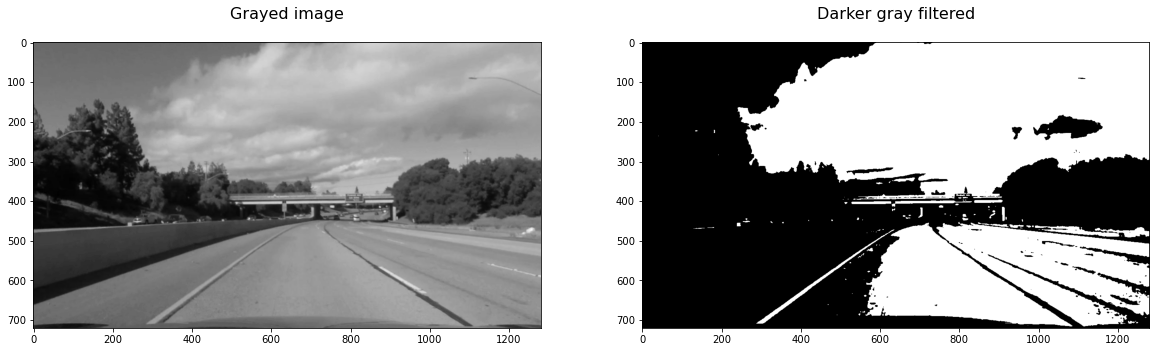

In [15]:
if RUN_TEST_IMG:
    # Transform BGR image to grayscale
    img_gray = cv2.cvtColor(img_blurred, cv2.COLOR_RGB2GRAY)
        
    img_gray_filtered = avg_grayness_filter(img_gray)
    f, (ax11, ax12) = plt.subplots(1, 2, figsize=(20, 10))
    ax11.set_title("Grayed image\n", fontsize=16)
    ax11.imshow(img_gray, cmap='gray')
    ax12.set_title("Darker gray filtered\n", fontsize=16)
    ax12.imshow(img_gray_filtered, cmap='gray')
    plt.show()

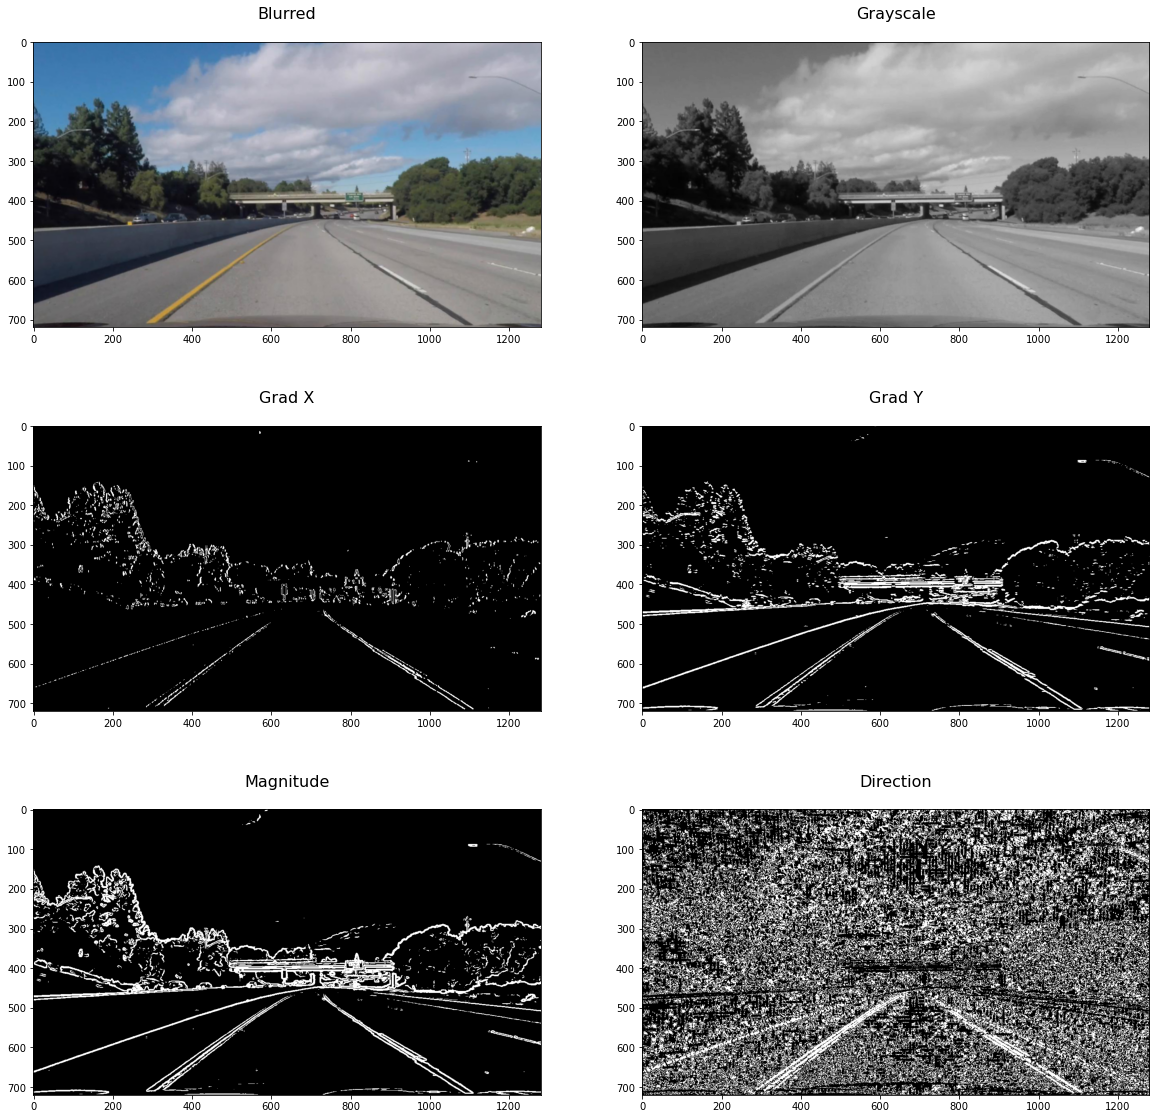

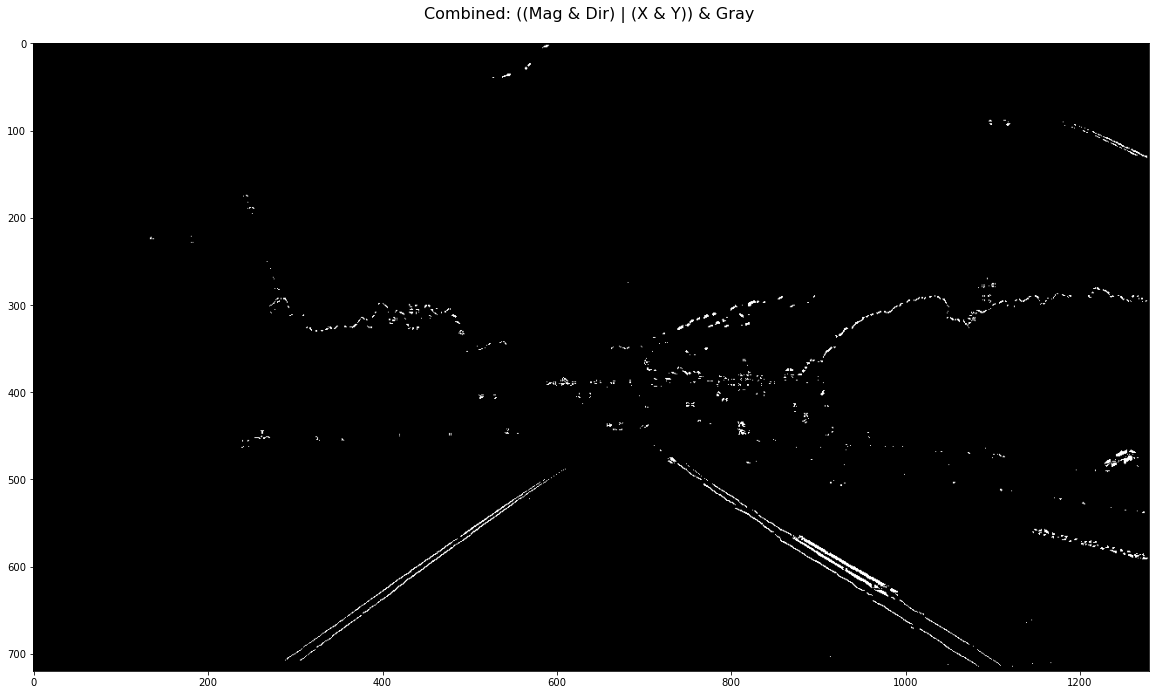

In [16]:
if RUN_TEST_IMG:
    # Transform BGR image to grayscale
    img_gray = cv2.cvtColor(img_blurred, cv2.COLOR_RGB2GRAY)

    # Get the results of each gradient thresholds
    grad_x_binary = abs_sobel_thresh(img_gray, orient='x', ksize=ksize, abs_thresh=abs_thresh_x)
    grad_y_binary = abs_sobel_thresh(img_gray, orient='y', ksize=ksize, abs_thresh=abs_thresh_y)   
    mag_binary = mag_threshold(img_gray, ksize=ksize, mag_thresh=mag_thresh)
    dir_binary = dir_threshold(img_gray, ksize=ksize, dir_thresh=dir_thresh)
    combined_gradient_binary = gradient_thresh_combine(img_blurred, ksize=ksize, abs_thresh_x=abs_thresh_x, abs_thresh_y=abs_thresh_y, mag_thresh=mag_thresh, dir_thresh=dir_thresh)

    f, ((ax11, ax21), (ax12, ax22), (ax13, ax23)) = plt.subplots(3, 2, figsize=(20, 20))

    ax11.set_title("Blurred\n", fontsize=16)
    ax11.imshow(img_blurred)
    ax21.set_title("Grayscale\n", fontsize=16)
    ax21.imshow(img_gray, cmap='gray')

    ax12.set_title("Grad X\n", fontsize=16)
    ax12.imshow(grad_x_binary, cmap='gray')
    ax22.set_title("Grad Y\n", fontsize=16)
    ax22.imshow(grad_y_binary, cmap='gray')

    ax13.set_title("Magnitude\n", fontsize=16)
    ax13.imshow(mag_binary, cmap='gray')
    ax23.set_title("Direction\n", fontsize=16)
    ax23.imshow(dir_binary, cmap='gray')

    plt.show()

    f, ax11 = plt.subplots(1, 1, figsize=(20, 20))
    ax11.set_title("Combined: ((Mag & Dir) | (X & Y)) & Gray \n", fontsize=16)
    ax11.imshow(combined_gradient_binary, cmap='gray')    

    plt.show()

### 5.3. Color channels filters
Got LUV and LAB additional filters idea from https://towardsdatascience.com/computer-vision-for-lane-finding-24ea77f25209

In [17]:
def color_thresh_combine(img_rgb, ksize=3, hls_thresh=[(0, 255), (0, 255), (0, 255)], luv_thresh=[(0, 255), (0, 255), (0, 255)], lab_thresh=[(0, 255), (0, 255), (0, 255)]):
    # Transform BGR image to HLS
    img_hls = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HLS)
    
    # Get the results of each color thresholds
    col_hls_h_binary = color_channel_threshold(img_hls, channel=0, ksize=ksize, col_thresh=hls_thresh[0])
    col_hls_l_binary = color_channel_threshold(img_hls, channel=1, ksize=ksize, col_thresh=hls_thresh[1])
    col_hls_s_binary = color_channel_threshold(img_hls, channel=2, ksize=ksize, col_thresh=hls_thresh[2])
    
    # Transform BGR image to LUV
    img_luv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2LUV)
    
    # Get the results of each color thresholds
    col_luv_l_binary = color_channel_threshold(img_luv, channel=0, ksize=ksize, col_thresh=luv_thresh[0])
    col_luv_u_binary = color_channel_threshold(img_luv, channel=1, ksize=ksize, col_thresh=luv_thresh[1])
    col_luv_v_binary = color_channel_threshold(img_luv, channel=2, ksize=ksize, col_thresh=luv_thresh[2])
    
    # Transform BGR image to LAB
    img_lab = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2LAB)
    
    # Get the results of each color thresholds
    col_lab_l_binary = color_channel_threshold(img_lab, channel=0, ksize=ksize, col_thresh=lab_thresh[0])
    col_lab_a_binary = color_channel_threshold(img_lab, channel=1, ksize=ksize, col_thresh=lab_thresh[1])
    col_lab_b_binary = color_channel_threshold(img_lab, channel=2, ksize=ksize, col_thresh=lab_thresh[2])
    
    # Combine the color thresholds filters together
    combined_color_thresh = np.zeros_like(img_rgb[:,:,0])
    combined_color_thresh[
        ((col_hls_h_binary == 1) & (col_hls_l_binary == 1) & (col_hls_s_binary == 1))
        | ((col_luv_l_binary == 1) & (col_luv_u_binary == 1) & (col_luv_v_binary == 1))
        | ((col_lab_l_binary == 1) & (col_lab_a_binary == 1) & (col_lab_b_binary == 1))
                         ] = 1
    
    return combined_color_thresh

def color_channel_threshold(img, channel=0, ksize=3, col_thresh=(0, 255)):        
    # Get specific color channel
    img_channel = img[:,:,channel]

    # Apply threshold
    col_binary = np.zeros_like(img_channel)
    col_binary[(img_channel >= col_thresh[0]) & (img_channel <= col_thresh[1])] = 1
    return col_binary

#### 5.3.1 Compute color filter

In [18]:
# Thresholds for HLS color filtering, that will all be combined together
hls_thresh=[(0, 255), (0, 255), (105, 255)] # [(Hue), (Lightness), (Saturation)]
luv_thresh=[(205, 255), (0, 255), (0, 255)] # [(L), (u), (v)]
lab_thresh=[(0, 255), (0, 255), (135, 200)] # [(L), (a), (b)]

#### 5.3.2 Display color filter

**HLS**

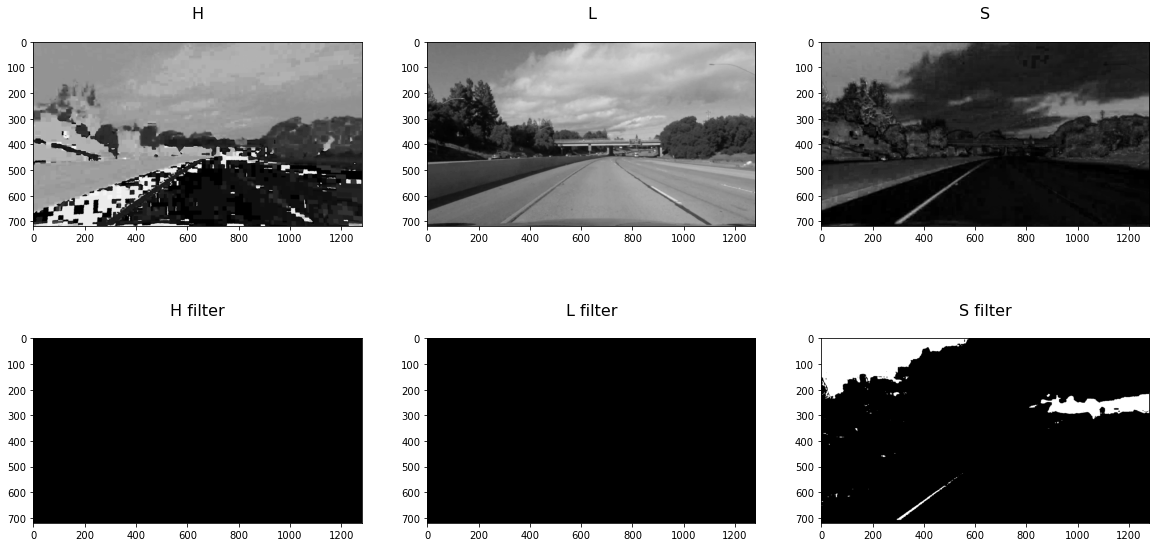

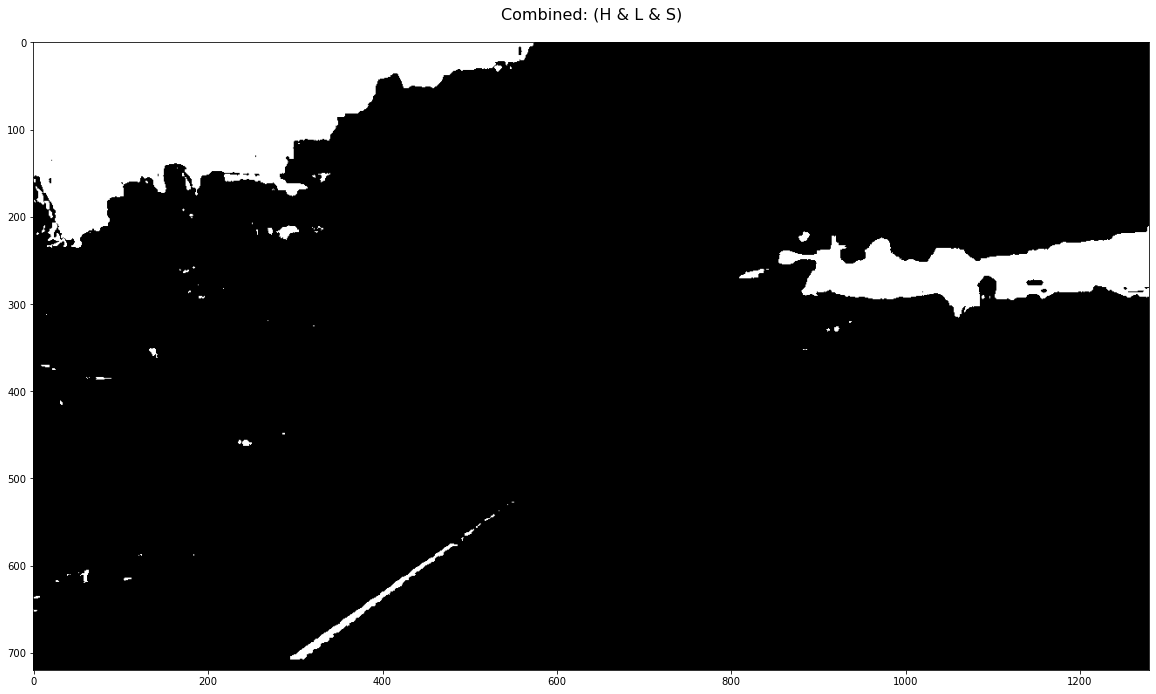

In [19]:
if RUN_TEST_IMG:
    # Transform BGR image to HLS
    img_hls = cv2.cvtColor(img_blurred, cv2.COLOR_RGB2HLS)

    # Get the results of each color thresholds
    col_hls_h_binary = color_channel_threshold(img_hls, channel=0, ksize=ksize, col_thresh=hls_thresh[0])
    col_hls_l_binary = color_channel_threshold(img_hls, channel=1, ksize=ksize, col_thresh=hls_thresh[1])
    col_hls_s_binary = color_channel_threshold(img_hls, channel=2, ksize=ksize, col_thresh=hls_thresh[2])

    # Combine the color thresholds filters together
    combined_hls_thresh = np.zeros_like(img_blurred[:,:,0])
    combined_hls_thresh[(col_hls_h_binary == 1) & (col_hls_l_binary == 1) & (col_hls_s_binary == 1)] = 1

    f, ((ax11, ax21, ax31), (ax12, ax22, ax32)) = plt.subplots(2, 3, figsize=(20, 10))

    ax11.set_title("H\n", fontsize=16)
    ax11.imshow(img_hls[:,:,0], cmap='gray')
    ax21.set_title("L\n", fontsize=16)
    ax21.imshow(img_hls[:,:,1], cmap='gray')
    ax31.set_title("S\n", fontsize=16)
    ax31.imshow(img_hls[:,:,2], cmap='gray')

    ax12.set_title("H filter\n", fontsize=16)
    ax12.imshow(col_hls_h_binary, cmap='gray')
    ax22.set_title("L filter\n", fontsize=16)
    ax22.imshow(col_hls_l_binary, cmap='gray')
    ax32.set_title("S filter\n", fontsize=16)
    ax32.imshow(col_hls_s_binary, cmap='gray')

    plt.show()

    f, ax11 = plt.subplots(1, 1, figsize=(20, 20))
    ax11.set_title("Combined: (H & L & S)\n", fontsize=16)
    ax11.imshow(combined_hls_thresh, cmap='gray')

    plt.show()

**LUV**

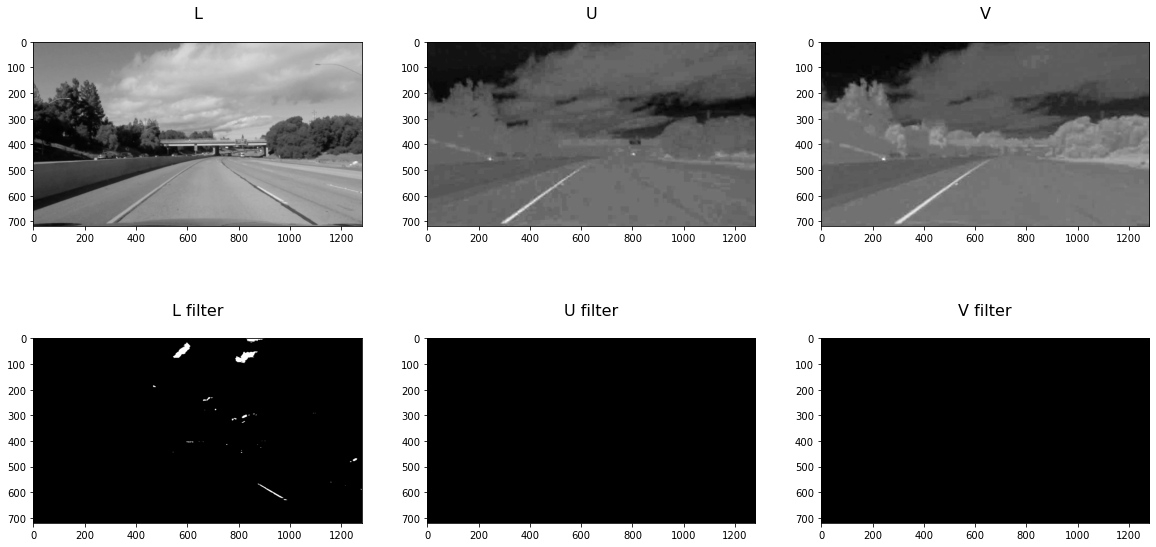

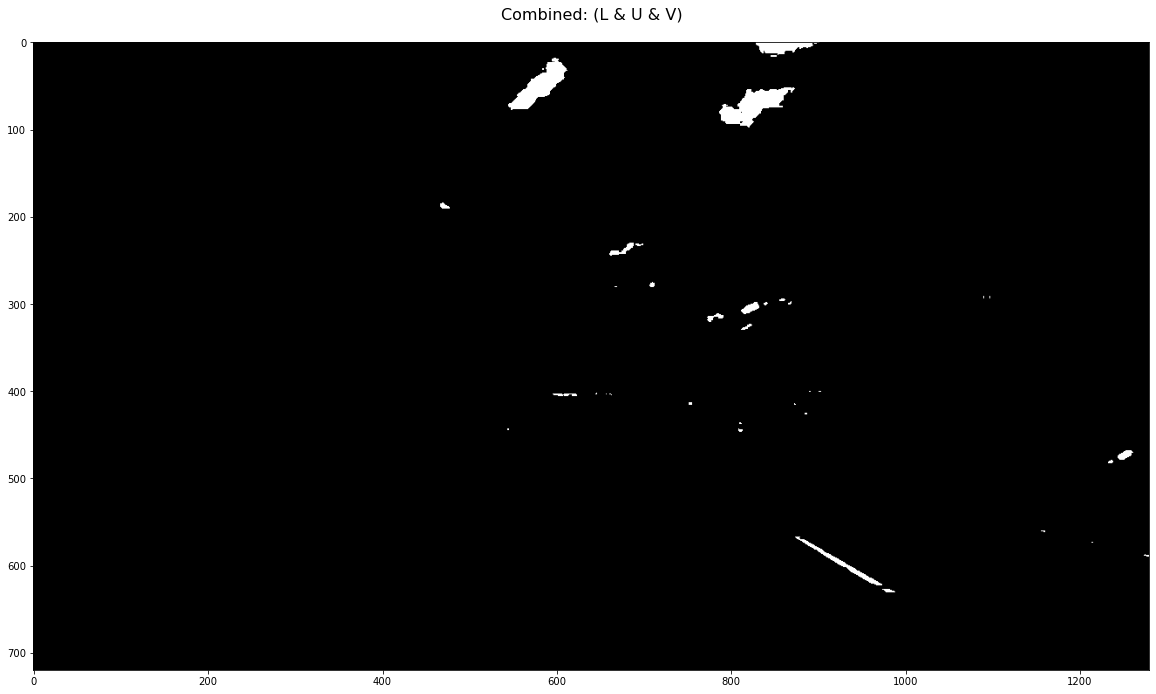

In [20]:
if RUN_TEST_IMG:
    # Transform BGR image to LUV
    img_luv = cv2.cvtColor(img_blurred, cv2.COLOR_RGB2LUV)

    # Get the results of each color thresholds
    col_luv_l_binary = color_channel_threshold(img_luv, channel=0, ksize=ksize, col_thresh=luv_thresh[0])
    col_luv_u_binary = color_channel_threshold(img_luv, channel=1, ksize=ksize, col_thresh=luv_thresh[1])
    col_luv_v_binary = color_channel_threshold(img_luv, channel=2, ksize=ksize, col_thresh=luv_thresh[2])

    # Combine the color thresholds filters together
    combined_luv_thresh = np.zeros_like(img_blurred[:,:,0])
    combined_luv_thresh[(col_luv_l_binary == 1) & (col_luv_u_binary == 1) & (col_luv_v_binary == 1)] = 1

    f, ((ax11, ax21, ax31), (ax12, ax22, ax32)) = plt.subplots(2, 3, figsize=(20, 10))

    ax11.set_title("L\n", fontsize=16)
    ax11.imshow(img_luv[:,:,0], cmap='gray')
    ax21.set_title("U\n", fontsize=16)
    ax21.imshow(img_luv[:,:,1], cmap='gray')
    ax31.set_title("V\n", fontsize=16)
    ax31.imshow(img_luv[:,:,2], cmap='gray')

    ax12.set_title("L filter\n", fontsize=16)
    ax12.imshow(col_luv_l_binary, cmap='gray')
    ax22.set_title("U filter\n", fontsize=16)
    ax22.imshow(col_luv_u_binary, cmap='gray')
    ax32.set_title("V filter\n", fontsize=16)
    ax32.imshow(col_luv_v_binary, cmap='gray')

    plt.show()

    f, ax11 = plt.subplots(1, 1, figsize=(20, 20))
    ax11.set_title("Combined: (L & U & V)\n", fontsize=16)
    ax11.imshow(combined_luv_thresh, cmap='gray')

    plt.show()

**LAB**

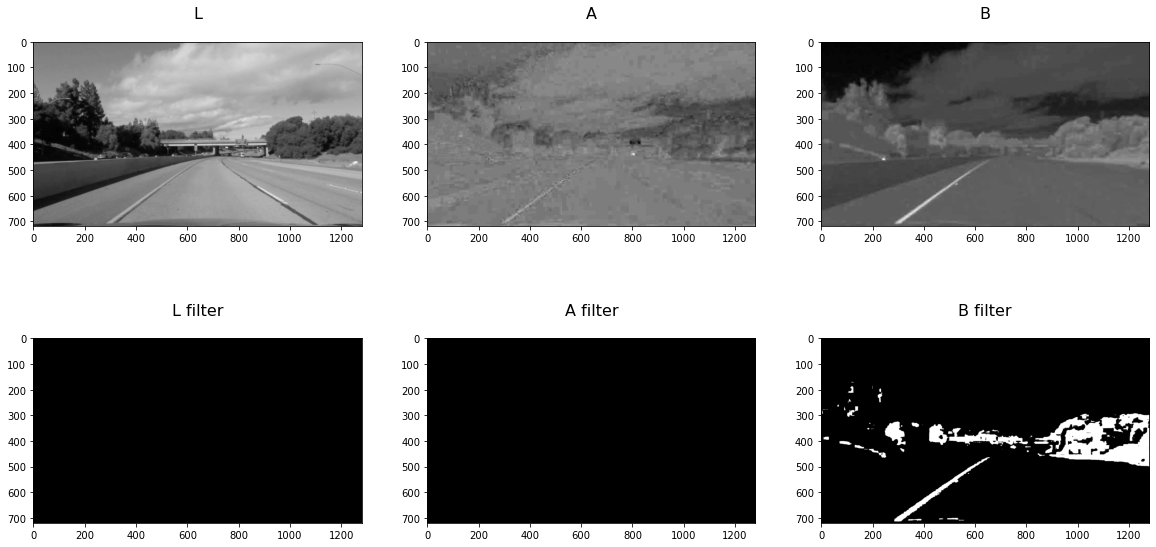

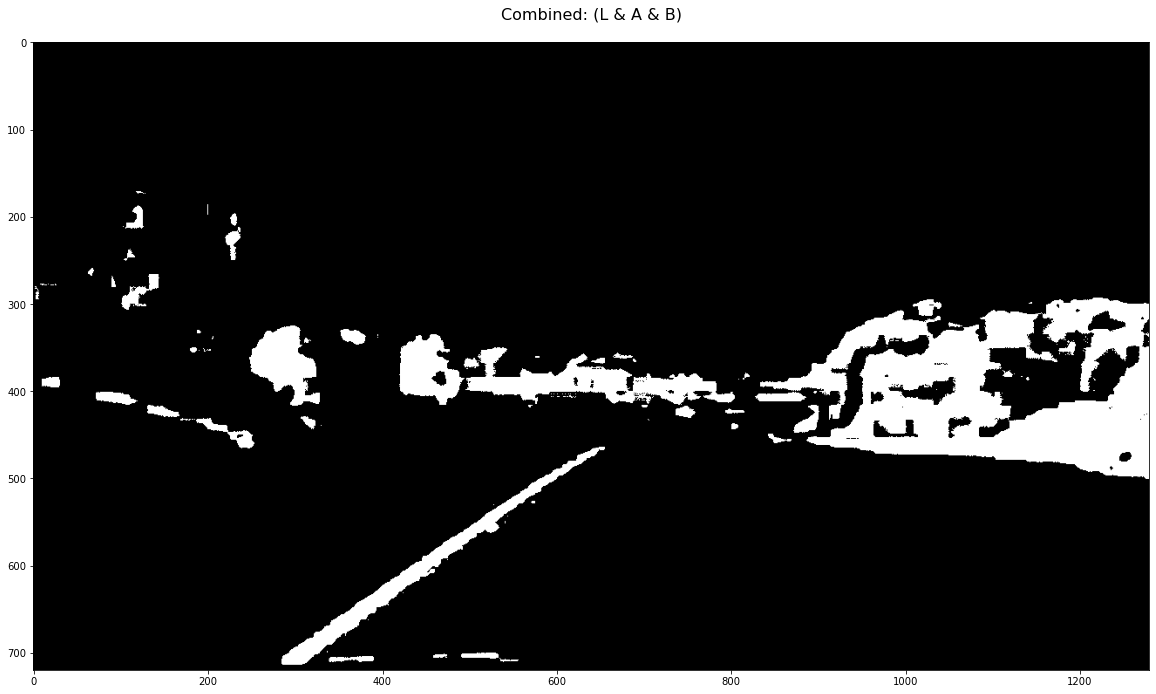

In [21]:
if RUN_TEST_IMG:
    # Transform BGR image to LAB
    img_lab = cv2.cvtColor(img_blurred, cv2.COLOR_RGB2LAB)

    # Get the results of each color thresholds
    col_lab_l_binary = color_channel_threshold(img_lab, channel=0, ksize=ksize, col_thresh=lab_thresh[0])
    col_lab_a_binary = color_channel_threshold(img_lab, channel=1, ksize=ksize, col_thresh=lab_thresh[1])
    col_lab_b_binary = color_channel_threshold(img_lab, channel=2, ksize=ksize, col_thresh=lab_thresh[2])

    # Combine the color thresholds filters together
    combined_lab_thresh = np.zeros_like(img_blurred[:,:,0])
    combined_lab_thresh[(col_lab_l_binary == 1) & (col_lab_a_binary == 1) & (col_lab_b_binary == 1)] = 1

    f, ((ax11, ax21, ax31), (ax12, ax22, ax32)) = plt.subplots(2, 3, figsize=(20, 10))

    ax11.set_title("L\n", fontsize=16)
    ax11.imshow(img_lab[:,:,0], cmap='gray')
    ax21.set_title("A\n", fontsize=16)
    ax21.imshow(img_lab[:,:,1], cmap='gray')
    ax31.set_title("B\n", fontsize=16)
    ax31.imshow(img_lab[:,:,2], cmap='gray')

    ax12.set_title("L filter\n", fontsize=16)
    ax12.imshow(col_lab_l_binary, cmap='gray')
    ax22.set_title("A filter\n", fontsize=16)
    ax22.imshow(col_lab_a_binary, cmap='gray')
    ax32.set_title("B filter\n", fontsize=16)
    ax32.imshow(col_lab_b_binary, cmap='gray')

    plt.show()

    f, ax11 = plt.subplots(1, 1, figsize=(20, 20))
    ax11.set_title("Combined: (L & A & B)\n", fontsize=16)
    ax11.imshow(combined_lab_thresh, cmap='gray')

    plt.show()

**Combined HLS LUV LAB filters**

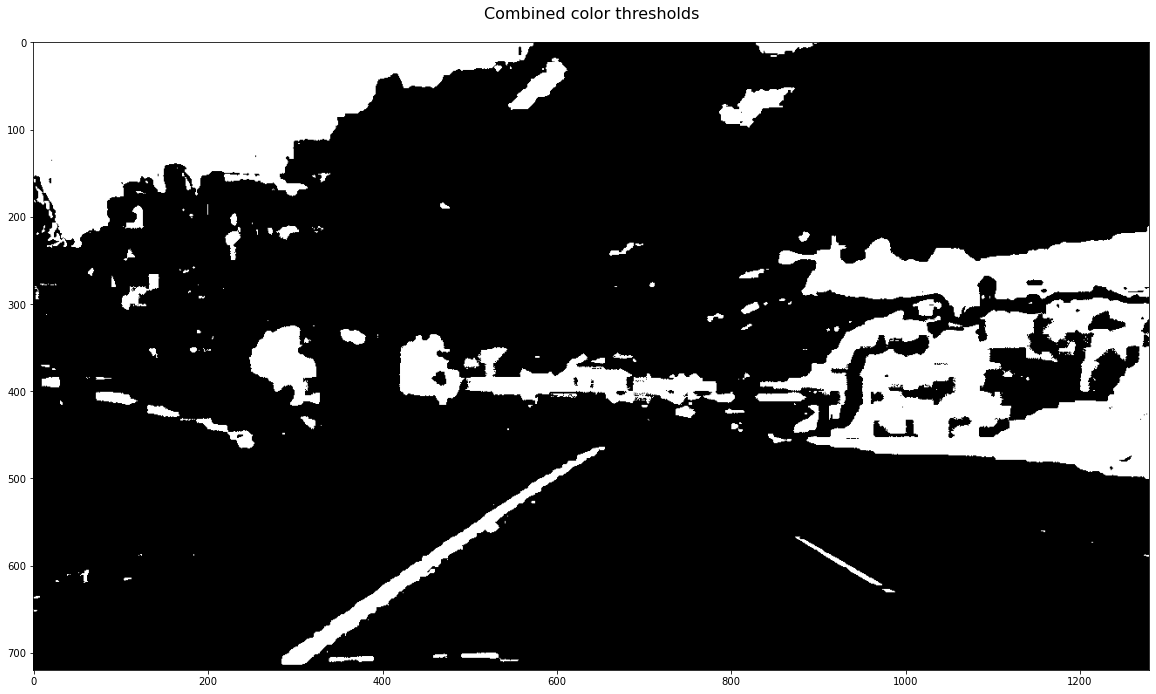

In [22]:
if RUN_TEST_IMG:
    combined_color_thresh = color_thresh_combine(img_blurred, ksize, hls_thresh, luv_thresh, lab_thresh)

    f, ax11 = plt.subplots(1, 1, figsize=(20, 20))
    ax11.set_title("Combined color thresholds\n", fontsize=16)
    ax11.imshow(combined_color_thresh, cmap='gray')

    plt.show()

### 5.4. Complete filter pipeline

In [23]:
def filter_pipeline(img_rgb, ksize=3, abs_thresh_x=(0, 255), abs_thresh_y=(0, 255), mag_thresh=(0, 255), dir_thresh=(0, np.pi/2), hls_thresh=[(0, 255), (0, 255), (0, 255)], luv_thresh=[(0, 255), (0, 255), (0, 255)], lab_thresh=[(0, 255), (0, 255), (0, 255)]):
    
    # Copy image not to alter source
    img_rgb = np.copy(img_rgb)

    # Apply gaussian blur
    img_blurred = gaussian_blur(img_rgb, ksize)
    
    # Compute gradient filter
    combined_gradient_thresh = gradient_thresh_combine(img_blurred, ksize=ksize, abs_thresh_x=abs_thresh_x, abs_thresh_y=abs_thresh_y, mag_thresh=mag_thresh, dir_thresh=dir_thresh)
    
    # Compute color channels filters
    combined_color_thresh = color_thresh_combine(img_blurred, ksize=ksize, hls_thresh=hls_thresh, luv_thresh=luv_thresh, lab_thresh=lab_thresh)
   
    # Combine gradient and color channels filters
    combined_gradient_color_thresh = np.zeros_like(img_rgb[:,:,0])
    combined_gradient_color_thresh[(combined_gradient_thresh==1) | (combined_color_thresh==1)] = 1
    
    #return combined_gradient_color_thresh
    return combined_gradient_color_thresh

#### 5.4.1 Display pipeline result filter

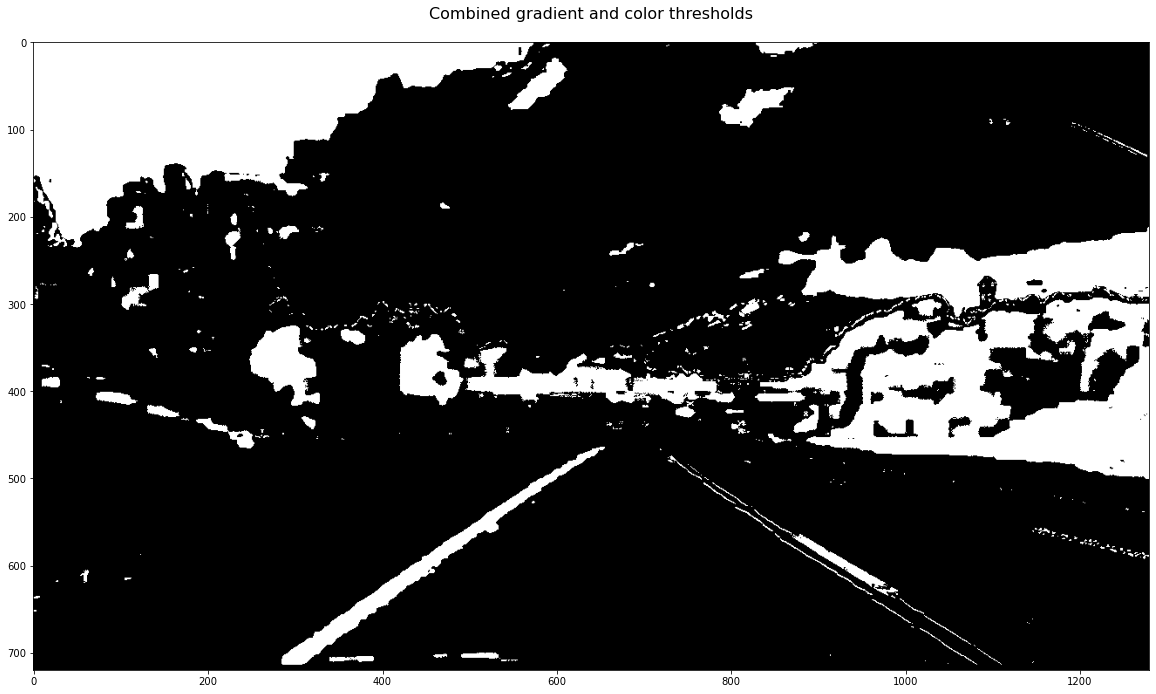

In [24]:
if RUN_TEST_IMG:
    # Filter generation pipeline
    img_filter = filter_pipeline(img_blurred, ksize, abs_thresh_x, abs_thresh_y, mag_thresh, dir_thresh, hls_thresh, luv_thresh, lab_thresh)

    f, ax11 = plt.subplots(1, 1, figsize=(20, 20))
    ax11.set_title("Combined gradient and color thresholds\n", fontsize=16)
    ax11.imshow(img_filter, cmap='gray')

    plt.show()

## 6. Region of interest & Perspective transform
Determine region of interest to and change perspective to perform filtering on
**Note** Reordered region of interest & perspective transform here to save image processing time and ease image filtering view/optimization

### 6.1. Region of interest 

In [25]:
def determine_region_of_interest(img, apex_width_pct=0.2, apex_height_pct=0.4, bottom_width_pct=1.0):
    # Define a four sided polygon to mask
    # Top left, top right, bottom right, bottom left
    
    # Quadrilatere top size
    apex_width = img.shape[1]*apex_width_pct
    apex_height = img.shape[0]*apex_height_pct
    bottom_width = img.shape[1]*bottom_width_pct
    
    # Quadrilatere points
    left_bottom = [(img.shape[1]-bottom_width)/2, img.shape[0]]
    right_bottom = [(img.shape[1]+bottom_width)/2, img.shape[0]]
    left_top = [(img.shape[1]-apex_width)/2, (img.shape[0]-apex_height)]
    right_top = [(img.shape[1]+apex_width)/2, (img.shape[0]-apex_height)]
    
    vertices=np.array([
            [left_top[0],left_top[1]], 
            [right_top[0],right_top[1]],
            [right_bottom[0],right_bottom[1]],
            [left_bottom[0],left_bottom[1]]
        ],
        dtype=np.int32)
    
    return vertices

def region_of_interest_mask(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    # Defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    # Defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 1
        
    # Filling pixels inside the polygon defined by "vertices" with the fill color
    # Don't forget to wrap vertices in an array
    cv2.fillPoly(mask, [vertices], ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    
    return masked_image

####  6.2.1. Determine region of interest

In [26]:
bottom_width_pct=0.85
apex_height_pct=0.36
apex_width_pct=0.113


In [27]:
if RUN_TEST_IMG:
    vertices = determine_region_of_interest(img_undistorted, apex_width_pct, apex_height_pct, bottom_width_pct)

####  6.2.2. Display region of interest 

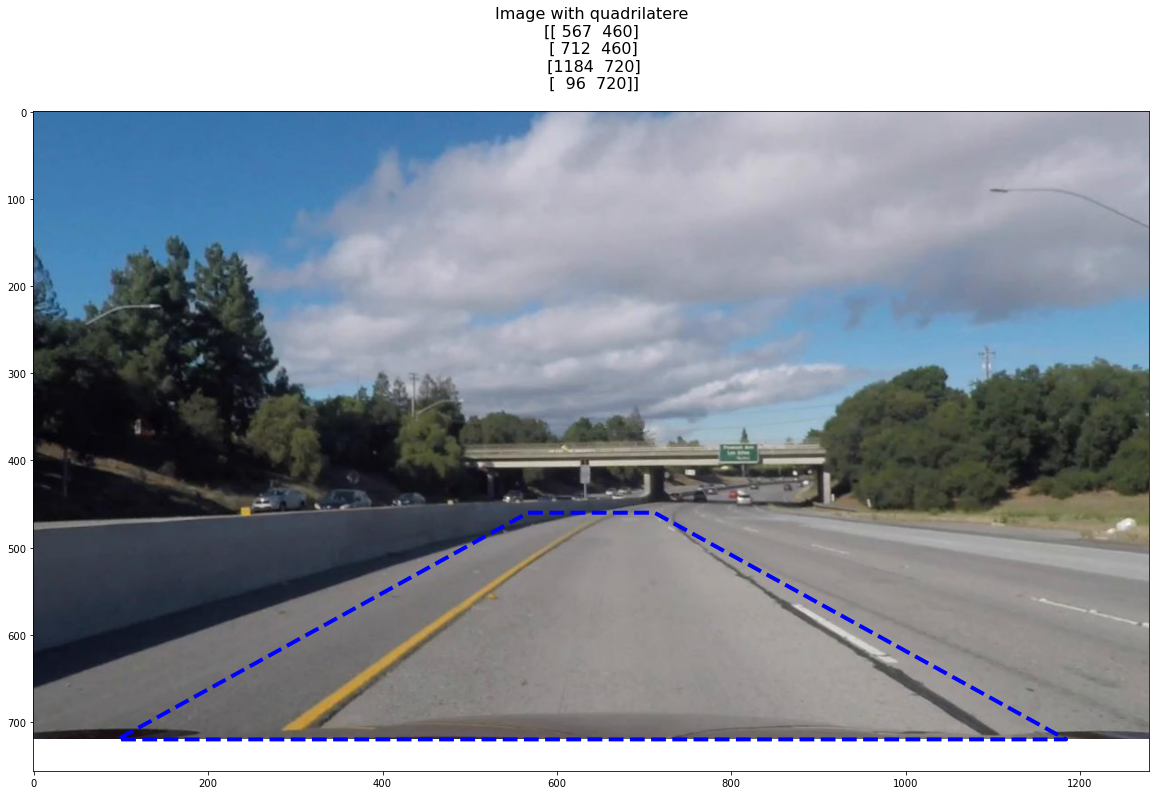

In [28]:
if RUN_TEST_IMG:
    # Plot the result
    f, (ax1) = plt.subplots(1, 1, figsize=(20, 20))

    ax1.imshow(img_undistorted)
    ax1.set_title('Image with quadrilatere\n{}\n'.format(vertices), fontsize=16)
    x = [vertices[0][0], vertices[1][0], vertices[2][0], vertices[3][0], vertices[0][0]]
    y = [vertices[0][1], vertices[1][1], vertices[2][1], vertices[3][1], vertices[0][1]]
    ax1.plot(x, y, 'b--', lw=4)

    plt.show()

### 6.3. Perspective transform
Apply a perspective transform to rectify binary image ("birds-eye view").

In [29]:
def determine_dst_region_of_interest(vertices):
    # Define a four sided destination rectangle    
    # Top left, top right, bottom right, bottom left
    dst_vertices=np.array([
            [vertices[3][0], 0], 
            [vertices[2][0], 0],
            [vertices[2][0], vertices[2][1]],
            [vertices[3][0], vertices[3][1]]
        ],
        dtype=np.int32)
    
    return dst_vertices

def birds_eye_view_warp(img, vertices, dst_vertices):    
    src = vertices.astype('float32')
    dst = dst_vertices.astype('float32')
      
    M = cv2.getPerspectiveTransform(src, dst) # The transformation matrix
    M_inv = cv2.getPerspectiveTransform(src, dst) # Inverse transformation
    
    warped_img = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR) # Image warping
    
    return warped_img, M, M_inv


####  6.3.1. Determine transforms

In [30]:
if RUN_TEST_IMG:
    dst_vertices = determine_dst_region_of_interest(vertices)
    
    img_warped_filtered, M, M_inv = birds_eye_view_warp(img_filter, vertices, dst_vertices)
    img_warped_unfiltered, M, M_inv = birds_eye_view_warp(img_undistorted, vertices, dst_vertices)

####  6.3.2. Display bird's eye view

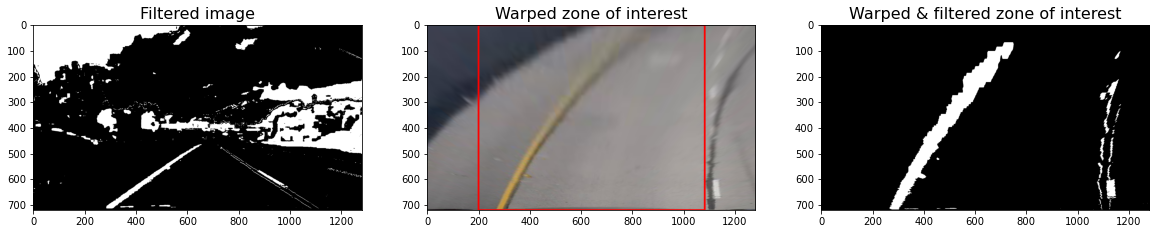

In [31]:
if RUN_TEST_IMG:
    # Plot the result
    f, (ax11, ax12, ax13) = plt.subplots(1, 3, figsize=(20, 20))


    ax11.imshow(img_filter, cmap='gray')
    ax11.set_title('Filtered image', fontsize=16)

    # Drawing perfect straight lanes
    img_warped_unfiltered_lanes = np.copy(img_warped_unfiltered)
    cv2.rectangle(img_warped_unfiltered_lanes, (200,0), (1080,720), (255, 0, 0), 5)
    ax12.imshow(img_warped_unfiltered_lanes)
    ax12.set_title('Warped zone of interest', fontsize=16)
    
    ax13.imshow(img_warped_filtered, cmap='gray')
    ax13.set_title('Warped & filtered zone of interest', fontsize=16)
    plt.show()

## 7. Lane detection and boundaries
Detect lane pixels and fit to find the lane boundary.

In [32]:
def find_lr_x_base(img, window=0, nwindows=9):
    # Window height based on nwindows above and image shape
    window_height = np.int(img.shape[0] // nwindows)
    
    # Take a histogram of the N window of the image
    upper_y_window = int(img.shape[0] - (window + 1) * window_height)
    lower_y_window = int(img.shape[0] - window * window_height)                                      
    histogram = np.sum(img[upper_y_window:lower_y_window, :], axis=0)
    
    # Find the peak of the left and right halves of the histogram
    midpoint = np.int(histogram.shape[0] // 2)
    
    # Set the starting point for the left and right lines
    left_x_base = np.argmax(histogram[:midpoint])
    right_x_base = np.argmax(histogram[midpoint:]) + midpoint
    
    return left_x_base, right_x_base

In [33]:
def find_lane_pixels(binary_warped, nwindows=9, margin=100, minpix=50):
    # TODO: Separate left from right lane detection logic so as not to reset both lanes on undetected lane
            
    # Take a histogram of the bottom half part of the image
    left_x_base, right_x_base = find_lr_x_base(binary_warped, 0, 2)
    
    # Window height based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0] // nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated later for each window in nwindows
    left_x_current = left_x_base
    right_x_current = right_x_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Rectangles to return
    left_rect = []
    right_rect = []
    
    missed_current_recenter_left = 0
    missed_current_recenter_right = 0
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window + 1) * window_height
        win_y_high = binary_warped.shape[0] - window * window_height
        
        # Determine boundaries of the window
        win_xleft_low = left_x_current - margin
        win_xleft_high = left_x_current + margin
        win_xright_low = right_x_current - margin
        win_xright_high = right_x_current + margin
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                          (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                           (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            
        # Rectangle to be saved to list
        l_rect = [(win_xleft_low, win_y_low), (win_xleft_high, win_y_high)]
        # If found pixels > minpix pixels, recenter next window
        # (`right_x_current` or `left_x_current`) on their mean position
        if len(good_left_inds) > minpix:
            # Update window rectangle position
            left_x_current = np.int(np.mean(nonzerox[good_left_inds]))
            missed_current_recenter_left = 0
        else:
            # Search local window band  (discard left)
            left_x_retry, _ = find_lr_x_base(binary_warped, window, nwindows)
            # Redo nonzero pixels computation
            win_xleft_low = left_x_retry - margin
            win_xleft_high = left_x_retry + margin
            good_left_inds_retry = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                              (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            # Recheck if minpix threshold was passed            
            if len(good_left_inds_retry) > minpix:
                current_retry_pixdiff = abs(left_x_current - np.int(np.mean(nonzerox[good_left_inds_retry]))) 
                if current_retry_pixdiff < (margin*missed_current_recenter_left*2.5):
                    good_left_inds = good_left_inds_retry
                    # Update window rectangle position
                    left_x_current = np.int(np.mean(nonzerox[good_left_inds]))
                    missed_current_recenter_left = 0

                    # Update good left rectangle
                    l_rect = [(win_xleft_low, win_y_low), (win_xleft_high, win_y_high)]
                else:
                    missed_current_recenter_left = missed_current_recenter_left + 1
            else:
                missed_current_recenter_left = missed_current_recenter_left + 1
            
        # Append the window rectangle for visualization image
        left_rect.append(l_rect)
        # Append found indices to the lists
        left_lane_inds.append(good_left_inds)
            
        # Rectangle to be saved to list
        r_rect = [(win_xright_low, win_y_low), (win_xright_high, win_y_high)]
        if len(good_right_inds) > minpix:
            # Update window rectangle position
            right_x_current = np.int(np.mean(nonzerox[good_right_inds]))
            missed_current_recenter_right = 0
        else:
            # Search local window band  (discard left)
            _, right_x_retry = find_lr_x_base(binary_warped, window, nwindows)
            # Redo nonzero pixels computation
            win_xright_low = right_x_retry - margin
            win_xright_high = right_x_retry + margin
            good_right_inds_retry = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                               (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Recheck if minpix threshold was passed
            if len(good_right_inds_retry) > minpix:
                current_retry_pixdiff = abs(right_x_current - np.int(np.mean(nonzerox[good_right_inds_retry])))
                if current_retry_pixdiff < (margin*missed_current_recenter_right*2.5):
                    good_right_inds = good_right_inds_retry
                    # Update window rectangle position
                    right_x_current = np.int(np.mean(nonzerox[good_right_inds]))
                    missed_current_recenter_right = 0
                    # Update good right rectangle
                    r_rect = [(win_xright_low, win_y_low), (win_xright_high, win_y_high)]
                else:
                    missed_current_recenter_right = missed_current_recenter_right + 1
            else:
                missed_current_recenter_right = missed_current_recenter_right + 1

        # Append the window rectangle for visualization image
        right_rect.append(r_rect)
        # Append found indices to the lists
        right_lane_inds.append(good_right_inds)

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, left_rect, right_rect

In [34]:
def find_lane_pixels_from_prior(binary_warped, nwindows=9, margin=100, minpix=50, left_lane_fit=None, right_lane_fit=None):
   
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Set the area of search based on activated x-values within the +/- margin of polynomial function
    win_xleft_low = (left_lane_fit[0]*(nonzeroy**2) + left_lane_fit[1]*nonzeroy + left_lane_fit[2] - margin)
    win_xleft_high = (left_lane_fit[0]*(nonzeroy**2) + left_lane_fit[1]*nonzeroy + left_lane_fit[2] + margin)
    win_xright_low = (right_lane_fit[0]*(nonzeroy**2) + right_lane_fit[1]*nonzeroy + right_lane_fit[2] - margin)
    win_xright_high = (right_lane_fit[0]*(nonzeroy**2) + right_lane_fit[1]*nonzeroy + right_lane_fit[2] + margin)
    
    # Identify the nonzero pixels
    left_lane_inds = (nonzerox > win_xleft_low) & (nonzerox < win_xleft_high)
    right_lane_inds = (nonzerox > win_xright_low) & (nonzerox < win_xright_high)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # TODO: Add average / Kalman filter to prevent glitches in positioning
    
    return leftx, lefty, rightx, righty, None, None

### 7.1. Detect lanes

In [35]:
nwindows=9
margin=60
minpix=50

### 7.2. Display lanes lanes

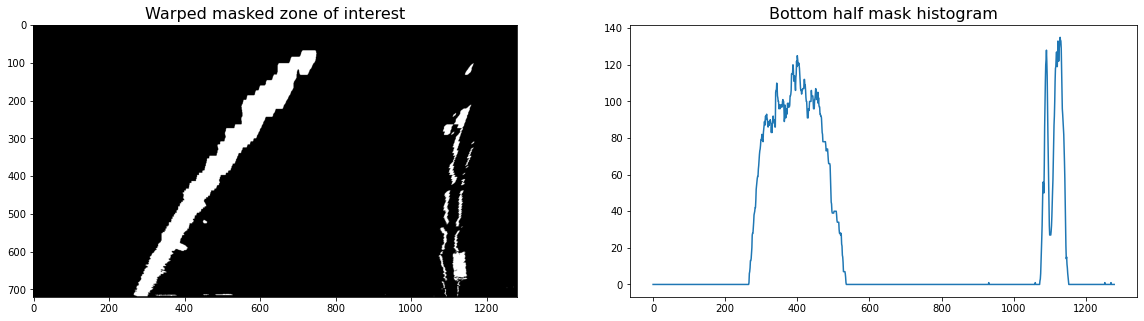

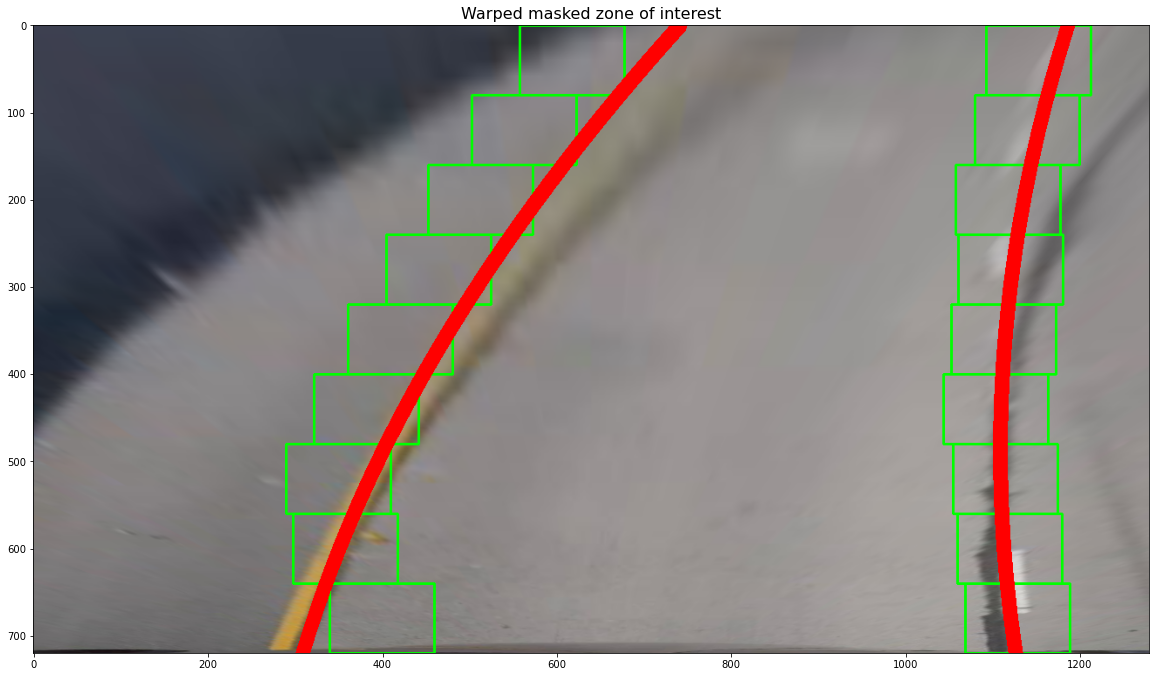

In [36]:
if RUN_TEST_IMG:
    leftx, lefty, rightx, righty, left_rect, right_rect = find_lane_pixels(
        img_warped_filtered, nwindows, margin, minpix)

    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Plot the result
    f, (ax11, ax12) = plt.subplots(1, 2, figsize=(20, 5))

    ax11.imshow(img_warped_filtered, cmap='gray')
    ax11.set_title('Warped masked zone of interest', fontsize=16)

    # Window height based on nwindows above and image shape
    window_height = np.int(img_warped_filtered.shape[0] // 2)
    
    # Take a histogram of the N window of the image
    upper_y_window = int(img_warped_filtered.shape[0] - window_height)
    lower_y_window = int(img_warped_filtered.shape[0]) 
    window = img_warped_filtered[upper_y_window:lower_y_window, :]
    
    histogram = np.sum(img_warped_filtered[upper_y_window:lower_y_window, :], axis=0)
    ax12.plot(histogram)    
    ax12.set_title('Bottom half mask histogram', fontsize=16)

    plt.show()
    
    f, (ax11) = plt.subplots(1, 1, figsize=(20, 20))
    
    # Draw rectangles
    img_warped_rect = np.copy(img_warped_unfiltered)
    for rect in left_rect:
        cv2.rectangle(img_warped_rect, (rect[0][0], rect[0][1]), (rect[1][0], rect[1][1]), (0, 255, 0), 2)
    for rect in right_rect:
        cv2.rectangle(img_warped_rect, (rect[0][0], rect[0][1]), (rect[1][0], rect[1][1]), (0, 255, 0), 2)

    # Draw lanes
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_warped_filtered.shape[0] - 1, img_warped_filtered.shape[0])
    try:
        left_fitx = np.maximum(left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2],0)
        right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1 * ploty ** 2 + 1 * ploty
        right_fitx = 1 * ploty ** 2 + 1 * ploty
    # Clip the array to prevent out of image pixels
    left_fitx = np.clip(left_fitx, 0, img_warped_rect.shape[1]-1)
    right_fitx = np.clip(right_fitx, 0, img_warped_rect.shape[1]-1) 

    # Colors in the left and right lane regions
    left_points = [[b,a] for a, b in zip(ploty.astype('int32'), left_fitx.astype('int32'))]    
    left_points=np.array([left_points], dtype=np.int32)
    cv2.polylines(img_warped_rect, left_points, False, (255,0,0), 16)
    right_points = [[b,a] for a, b in zip(ploty.astype('int32'), right_fitx.astype('int32'))]    
    right_points=np.array([right_points], dtype=np.int32)
    cv2.polylines(img_warped_rect, right_points, False, (255,0,0), 16)

    ax11.imshow(img_warped_rect)
    ax11.set_title('Warped masked zone of interest', fontsize=16)

## 8. Lane curvature
Determine the curvature of the lane and vehicle position with respect to center.

In [37]:
def measure_curvature_real(binary_warped, left_fitx, right_fitx, ym_per_pix, xm_per_pix):
    # Find our lane pixels first
    # Define conversions in x and y from pixels space to meters
    #ym_per_pix = meters per pixel in y dimension
    #xm_per_pix = meters per pixel in x dimension
    ploty = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])
    
    # Define y-value where we want radius of curvature
    y_eval = np.max(ploty)
    
    # Fit for world space
    left_fit_xm = np.polyfit(ploty * ym_per_pix, left_fitx * xm_per_pix, 2)
    right_fit_xm = np.polyfit(ploty * ym_per_pix, right_fitx * xm_per_pix, 2)
    
    ## Implement the calculation of the left line here
    left_curverad = ((1 + (2 * left_fit_xm[0] * y_eval * ym_per_pix + left_fit_xm[1]) ** 2) ** (3 / 2)) / np.abs(2 * left_fit_xm[0])
    ## Implement the calculation of the right line here
    right_curverad = ((1 + (2 * right_fit_xm[0] * y_eval * ym_per_pix + right_fit_xm[1]) ** 2) ** (3 / 2)) / np.abs(2 * right_fit_xm[0])
    
    return left_curverad, right_curverad

### 8.1 Determine lane curvature

In [38]:
# Almost same height as course, reusing parameters
ym_per_pix=30/720
xm_per_pix=3.7/675 # Average lane width in birds eye view is 675px



### 8.2 Overlay lane curvature

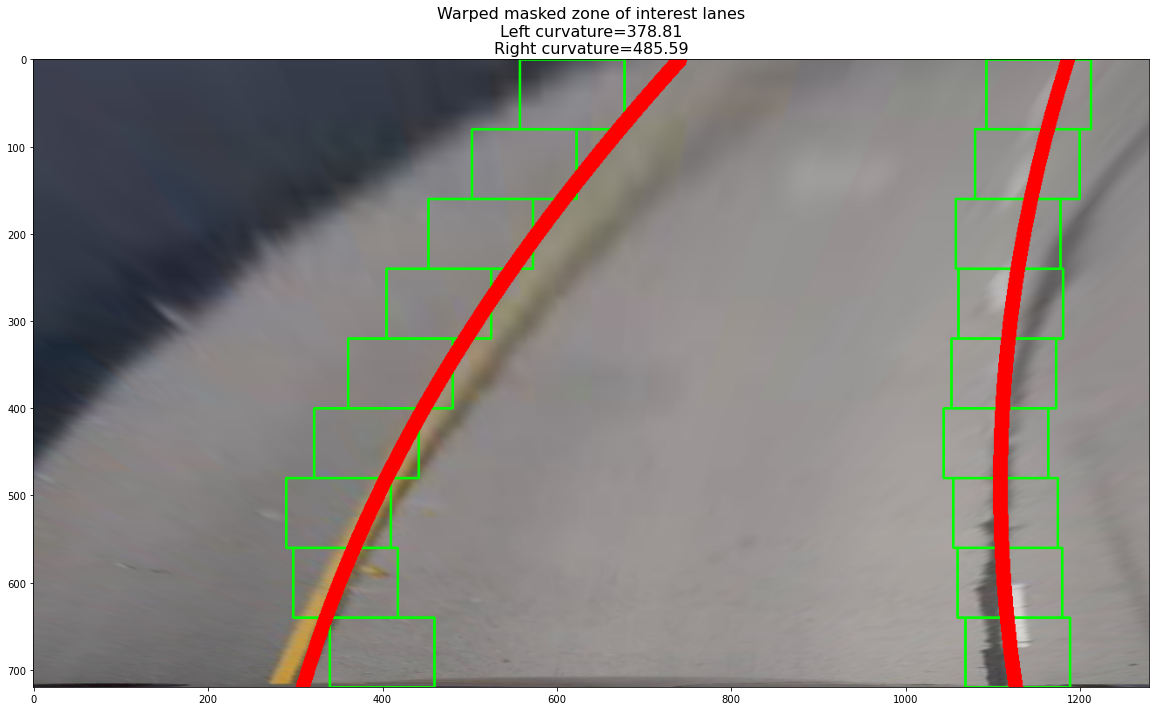

In [39]:
if RUN_TEST_IMG:
    left_curverad, right_curverad = measure_curvature_real(img_warped_filtered, left_fitx, right_fitx, ym_per_pix, xm_per_pix)
    # Plot the result
    f, ax1 = plt.subplots(1, 1, figsize=(20, 20))

    ax1.imshow(img_warped_rect)
    ax1.set_title('Warped masked zone of interest lanes\nLeft curvature={:6.2f}\nRight curvature={:6.2f}'.format(
        left_curverad, right_curverad), fontsize=16)

    plt.show()


## 9. Vehicle position
Detect the vehicle position against the center in meters

In [40]:
def determine_vehicle_position(binary_warped, left_fit, right_fit):    
    
    # Define y-value where we want to compute distance
    y_eval = binary_warped.shape[0]-1
    
    # Implement the calculation of the left line here
    left_lane_pos = (left_fit[0] * (y_eval**2) + left_fit[1] * y_eval + left_fit[2])
    # Implement the calculation of the right line here
    right_lane_pos = (right_fit[0] * (y_eval**2) + right_fit[1] * y_eval + right_fit[2])
    
    # Center of the lane
    lane_center_pos = left_lane_pos + ((right_lane_pos - left_lane_pos) / 2)
    
    # Left from center is negative values / Right from center is positive values
    vehicle_position = lane_center_pos - (binary_warped.shape[1] / 2)
    
    # Assuming USA 3.7m between lanes
    xm_per_pix = 3.7 / (right_lane_pos - left_lane_pos)
    vehicle_position_meter = vehicle_position * xm_per_pix
   
    return vehicle_position_meter, lane_center_pos, vehicle_position

### 9.1 Determine vehicle position

In [41]:
if RUN_TEST_IMG:
    vehicle_position_meter, lane_center_pos, vehicle_position = determine_vehicle_position(img_warped_filtered, left_fit, right_fit)

    print('Vehicle is {:2.2f} metters away from lane center'.format(vehicle_position_meter))

Vehicle is 0.36 metters away from lane center


## 10. Original image and lane superposition
Warp the detected lane boundaries back onto the original image.
Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [42]:
def unwarp_lanes(img, ploty, left_fitx, right_fitx, vertices, dst_vertices, lane_color=(255,63,63), fill_color=(50,255,50), thickness=20):
    
    lanes_binary = np.zeros_like(img)
    
    # Colors in the left and right lane regions
    left_points = [[b,a] for a, b in zip(ploty.astype('int32'), left_fitx.astype('int32'))]    
    right_points = [[b,a] for a, b in zip(ploty.astype('int32'), right_fitx.astype('int32'))]    
    
    left_points=np.array([np.flipud(left_points)], dtype=np.int32)    
    right_points=np.array([right_points], dtype=np.int32)
    lr_points = np.hstack((left_points, right_points))

    cv2.fillPoly(lanes_binary, [lr_points], fill_color)
        
    cv2.polylines(lanes_binary, left_points, False, lane_color, thickness)
    cv2.polylines(lanes_binary, right_points, False, lane_color, thickness)
    
    src = vertices.astype('float32')
    dst = dst_vertices.astype('float32')
    
    M_inv = cv2.getPerspectiveTransform(dst, src) # Inverse transformation
    
    unwarped_img = cv2.warpPerspective(
        lanes_binary, M_inv, (lanes_binary.shape[1], lanes_binary.shape[0]), flags=cv2.INTER_LINEAR) # Image warping
    
    return unwarped_img

def overlay_text(img, pos, text, color=(255,255,255)):
    # Inspired from https://stackoverflow.com/questions/16615662/how-to-write-text-on-a-image-in-windows-using-python-opencv2
    # Create a black image    
    img_overlay = np.zeros_like(img)

    font                   = cv2.FONT_HERSHEY_SIMPLEX
    bottomLeftCornerOfText = pos
    fontScale              = 0.5
    fontColor              = color
    lineType               = 2

    cv2.putText(img_overlay,text, 
        bottomLeftCornerOfText, 
        font, 
        fontScale,
        fontColor,
        lineType)

    return img_overlay


def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the mask    
    `initial_img` is the real image
    
    The result image is computed as follows:    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

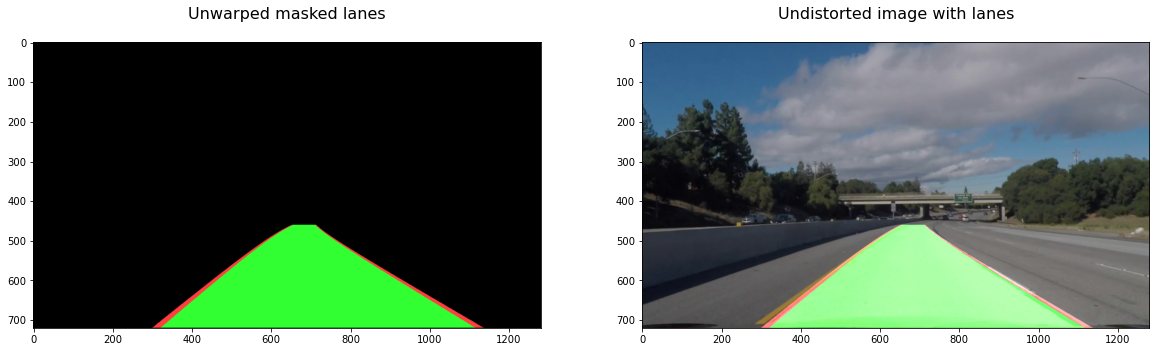

In [43]:
if RUN_TEST_IMG:
    img_unwarped_lanes_mask = unwarp_lanes(img_undistorted, ploty, left_fitx, right_fitx, vertices, dst_vertices)
    img_weighted = weighted_img(img_unwarped_lanes_mask, img_undistorted, α=0.8, β=1., γ=0.)

    # Plot the result
    f, ((ax11), (ax12)) = plt.subplots(1, 2, figsize=(20, 20))

    ax11.imshow(img_unwarped_lanes_mask, cmap='gray')
    ax11.set_title('Unwarped masked lanes\n', fontsize=16)

    ax12.imshow(img_weighted)
    ax12.set_title('Undistorted image with lanes\n', fontsize=16)

    plt.show()

## 11. Full pipeline for successive processing

In [44]:
def average_prev_x(new_x, prev_xs, depth = 5):    
    if prev_xs is None or len(prev_xs) == 0:
        # No average to be done, return current X and add current Xs to previous Xs list
        prev_xs = np.array([new_x],dtype=np.float32)
    else:
        # Initialize average list
        if len(prev_xs) >= depth:
            prev_xs = np.delete(prev_xs, depth-1, axis=0)
        # Add new historical values
        prev_xs = np.append([new_x], prev_xs, axis=0)
        
    # Return average of each X corresponding to one specific image Y
    avg_x = np.mean(prev_xs, axis=0)
    return avg_x, prev_xs

def compute_fitx(fit_video, ploty, img):
    try:
        fitx = fit_video[0] * ploty ** 2 + fit_video[1] * ploty + fit_video[2]
    except TypeError:
        # Avoids an error if `left` and `right` fit are still none or incorrect
        print('The function failed to fit a line!')
        fitx = 1 * ploty ** 2 + 1 * ploty

    # Clip the array to prevent out of image pixels
    fitx = np.clip(fitx, 0, img.shape[1]-1)
    return fitx

In [45]:
def process_image(image, calib_mtx, calib_dist):
    global left_fit_video
    global right_fit_video
    global vertices
    global dst_vertices
    global ploty
    global prev_left_fit
    global prev_right_fit
    global prev_left_fitxs
    global prev_right_fitxs
    
    # Uncomment to save each image
    #save_images(image, "video")
    
    try:
        if vertices is None:
            vertices = determine_region_of_interest(image, apex_width_pct, apex_height_pct, bottom_width_pct)
            dst_vertices = determine_dst_region_of_interest(vertices)
            
        # 4. Undistort
        img_undistorted = cv2.undistort(image, calib_mtx, calib_dist, None, calib_mtx)        
        
        # 5. Image filtering
        img_filtered = filter_pipeline(
            img_undistorted, ksize, abs_thresh_x, abs_thresh_y, mag_thresh, dir_thresh, hls_thresh, luv_thresh, lab_thresh)
        # Uncomment to save filtered image
        #save_images(img_filtered, "video_f")
        
        # 6. Perspective transform
        img_warped_filtered, M, M_inv = birds_eye_view_warp(img_filtered, vertices, dst_vertices)
        # Uncomment to save filtered warped image
        #save_images(img_filtered, "video_fw")
        
        # 7. Lane detection and boundaries
        
        ## TODO: Separate left from right lane
        # Execute from prior if lanes were already detected
        if left_fit_video is not None:            
            leftx, lefty, rightx, righty, left_rect, right_rect = find_lane_pixels_from_prior(
                img_warped_filtered, nwindows, margin, minpix, left_fit_video, right_fit_video)
            
            # If too little pixels are detected, fall back to standard lane finding 
            if((len(leftx) < (minpix*nwindows)) or (len(rightx) < (minpix*nwindows))):
                leftx, lefty, rightx, righty, left_rect, right_rect = find_lane_pixels(
                    img_warped_filtered, nwindows, margin, minpix)
        else:
            leftx, lefty, rightx, righty, left_rect, right_rect = find_lane_pixels(
                img_warped_filtered, nwindows, margin, minpix)

        # Compute lane fit
        left_fit_video = np.polyfit(lefty, leftx, 2)
        right_fit_video = np.polyfit(righty, rightx, 2)
        
        # Generate Y (once) coordinates for plotting
        if ploty is None:
            ploty = np.linspace(0, img_warped_filtered.shape[0] - 1, img_warped_filtered.shape[0])
            
        # Compute left and right X coordinates for plotting
        left_fitx = compute_fitx(left_fit_video, ploty, img_warped_filtered)
        right_fitx = compute_fitx(right_fit_video, ploty, img_warped_filtered)
        
        # Compute average left and right fit X values
        ## TODO: Compute only if necessary, start appending until threshold is reached
        avg_left_fitx, prev_left_fitxs = average_prev_x(left_fitx, prev_left_fitxs, average_prev_x_depth)
        avg_right_fitx, prev_right_fitxs = average_prev_x(right_fitx, prev_right_fitxs, average_prev_x_depth)
        
        # Use average left and right fit X values once we have attained threshold
        if len(prev_left_fitxs) >= average_prev_x_depth:
            left_fitx = avg_left_fitx
            right_fitx = avg_right_fitx
            left_fit_video = np.polyfit(ploty, avg_left_fitx, 2)
            right_fit_video = np.polyfit(ploty, avg_right_fitx, 2)
        
        left_curverad, right_curverad = measure_curvature_real(
            img_warped_filtered, left_fitx, right_fitx, ym_per_pix, xm_per_pix)
        vehicle_position_meter, lane_center_pos, vehicle_position = determine_vehicle_position(
            img_warped_filtered, left_fit_video, right_fit_video)
        
        # If lanes points distance standard deviation is getting too high, reset fit for next iteration
        dst_std_dev_lr = np.std(left_fitx - right_fitx) > lanes_dst_std_dev_max
        if dst_std_dev_lr > lanes_dst_std_dev_max:
            left_fit_video = None
            right_fit_video = None
            
        # If lanes bottom half relative distances too big or low, reset fit for next iteration
        avg_rel_dst_lr = np.average(right_fitx[int(len(right_fitx)/3):] - left_fitx[int(len(left_fitx)/3):])        
        if lanes_avg_rel_dst_min > avg_rel_dst_lr or avg_rel_dst_lr > lanes_avg_rel_dst_max:            
            print("Reset relative length {}".format(avg_rel_dst_lr))
            left_fit_video = None
            right_fit_video = None
            
        img_unwarped_lanes_mask = unwarp_lanes(img_undistorted, ploty, left_fitx, right_fitx, vertices, dst_vertices)
        img_weighted = weighted_img(img_unwarped_lanes_mask, img_undistorted, α=0.8, β=1., γ=0.)
        
        img_overlay_text = overlay_text(
            img_undistorted,
            (50,100),
            "Left curve: {:.2f}m / Right curve: {:.2f}m / Dst. center: {:.2f}m".format(
                left_curverad, right_curverad, vehicle_position_meter),
            color=(255,255,255))
        img_weighted = weighted_img(img_overlay_text, img_weighted, α=0.8, β=1., γ=0.)
        
        
    except:
        # Save image that causes errors for further calibration
        save_images(image, "error")        
        raise
    return img_weighted

def save_images(image, slug):
    # Find next vailable name for image
    i = 0
    file_name = "test_images/{}_{}.jpg".format(slug, i)
    while os.path.isfile(file_name):
        i = i + 1        
        file_name = "test_images/{}_{}.jpg".format(slug, i)
        
    # Save image and return name
    mpimg.imsave(file_name, image)
    return file_name

## 12. Video processing

### 12.1. Project video

In [61]:
if RUN_PROJECT_VIDEO == True:
    average_prev_x_depth = 10
    lanes_dst_std_dev_max = 80
    lanes_avg_rel_dst_min = 825
    lanes_avg_rel_dst_max = 925
  
    # Reset variables
    left_fit_video = None
    right_fit_video = None
    vertices = None
    dst_vertices = None
    ploty = None
    prev_left_fit = []
    prev_right_fit = []
    prev_left_fitxs = None
    prev_right_fitxs = None

    clip_path = VIDEO_PATH_PROJECT
    clip_processed_path = '{}processed.mp4'.format(clip_path.replace(".mp4", "_"))
    clip = VideoFileClip(clip_path)
    clip_processed = clip.fl_image(lambda image: process_image(image, calib_mtx, calib_dist))

    %time clip_processed.write_videofile(clip_processed_path, audio=False)

t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video project_video_processed.mp4.
Moviepy - Writing video project_video_processed.mp4




t:  20%|█▉        | 246/1260 [01:38<07:11,  2.35it/s, now=None]


t:  39%|███▉      | 490/1260 [03:19<05:15,  2.44it/s, now=None]


t:  40%|████      | 504/1260 [03:25<05:11,  2.43it/s, now=None]

Reset relative length 927.3592950338035



t:  40%|████      | 505/1260 [03:25<05:14,  2.40it/s, now=None]

Reset relative length 929.335688942606



t:  40%|████      | 506/1260 [03:26<05:15,  2.39it/s, now=None]

Reset relative length 930.9735577143117



t:  40%|████      | 507/1260 [03:26<05:22,  2.34it/s, now=None]

Reset relative length 933.1922254168696



t:  40%|████      | 508/1260 [03:27<05:21,  2.34it/s, now=None]

Reset relative length 935.6311688759954



t:  40%|████      | 509/1260 [03:27<05:17,  2.37it/s, now=None]

Reset relative length 938.144546910203



t:  40%|████      | 510/1260 [03:27<05:14,  2.38it/s, now=None]

Reset relative length 940.2177463442172



t:  41%|████      | 511/1260 [03:28<05:14,  2.39it/s, now=None]

Reset relative length 941.4704304755578



t:  41%|████      | 512/1260 [03:28<05:16,  2.37it/s, now=None]

Reset relative length 941.5380654068179



t:  41%|████      | 513/1260 [03:29<05:13,  2.38it/s, now=None]

Reset relative length 940.1323994957739



t:  41%|████      | 514/1260 [03:29<05:12,  2.38it/s, now=None]

Reset relative length 938.2492321459798



t:  41%|████      | 515/1260 [03:30<05:13,  2.38it/s, now=None]

Reset relative length 936.7266342377103



t:  41%|████      | 516/1260 [03:30<05:25,  2.28it/s, now=None]

Reset relative length 934.827032275698



t:  41%|████      | 517/1260 [03:30<05:25,  2.29it/s, now=None]

Reset relative length 933.348943674831



t:  41%|████      | 518/1260 [03:31<05:26,  2.27it/s, now=None]

Reset relative length 932.3995810042414



t:  41%|████      | 519/1260 [03:31<05:20,  2.31it/s, now=None]

Reset relative length 931.9356761618235



t:  41%|████▏     | 520/1260 [03:32<05:16,  2.34it/s, now=None]

Reset relative length 931.9329056822272



t:  41%|████▏     | 521/1260 [03:32<05:13,  2.36it/s, now=None]

Reset relative length 930.8621428370824



t:  41%|████▏     | 522/1260 [03:33<05:11,  2.37it/s, now=None]

Reset relative length 930.0625973212601



t:  42%|████▏     | 523/1260 [03:33<05:09,  2.38it/s, now=None]

Reset relative length 930.0631842218512



t:  42%|████▏     | 524/1260 [03:33<05:10,  2.37it/s, now=None]

Reset relative length 930.9077187356098



t:  42%|████▏     | 525/1260 [03:34<05:09,  2.38it/s, now=None]

Reset relative length 930.4380374933711



t:  42%|████▏     | 526/1260 [03:34<05:06,  2.39it/s, now=None]

Reset relative length 929.850373890233



t:  42%|████▏     | 527/1260 [03:35<05:06,  2.39it/s, now=None]

Reset relative length 929.8397859813441



t:  42%|████▏     | 528/1260 [03:35<05:18,  2.30it/s, now=None]

Reset relative length 929.8550117606304



t:  42%|████▏     | 529/1260 [03:36<05:14,  2.32it/s, now=None]

Reset relative length 931.1520720156116



t:  42%|████▏     | 530/1260 [03:36<05:13,  2.33it/s, now=None]

Reset relative length 931.1511223103521



t:  42%|████▏     | 531/1260 [03:36<05:08,  2.36it/s, now=None]

Reset relative length 930.4089580804783



t:  42%|████▏     | 532/1260 [03:37<05:06,  2.38it/s, now=None]

Reset relative length 928.9442375659496



t:  42%|████▏     | 533/1260 [03:37<05:07,  2.37it/s, now=None]

Reset relative length 925.1793100194662



t:  45%|████▌     | 572/1260 [03:57<05:21,  2.14it/s, now=None]

Reset relative length 927.6664533691273



t:  45%|████▌     | 573/1260 [03:57<05:15,  2.18it/s, now=None]

Reset relative length 932.2951500588313



t:  46%|████▌     | 574/1260 [03:58<05:09,  2.21it/s, now=None]

Reset relative length 936.7413973878756



t:  46%|████▌     | 575/1260 [03:58<05:03,  2.26it/s, now=None]

Reset relative length 941.7559080775068



t:  46%|████▌     | 576/1260 [03:58<04:58,  2.29it/s, now=None]

Reset relative length 946.4862886548673



t:  46%|████▌     | 577/1260 [03:59<04:56,  2.31it/s, now=None]

Reset relative length 950.6390919431782



t:  46%|████▌     | 578/1260 [03:59<04:52,  2.34it/s, now=None]

Reset relative length 954.8023251085082



t:  46%|████▌     | 579/1260 [04:00<04:48,  2.36it/s, now=None]

Reset relative length 957.8515061636588



t:  46%|████▌     | 580/1260 [04:00<04:46,  2.37it/s, now=None]

Reset relative length 959.4440453927554



t:  46%|████▌     | 581/1260 [04:01<04:46,  2.37it/s, now=None]

Reset relative length 961.300480049738



t:  46%|████▌     | 582/1260 [04:01<04:44,  2.38it/s, now=None]

Reset relative length 960.5836610824678



t:  46%|████▋     | 583/1260 [04:01<04:45,  2.37it/s, now=None]

Reset relative length 957.9078252288481



t:  46%|████▋     | 584/1260 [04:02<04:49,  2.34it/s, now=None]

Reset relative length 954.0841147874443



t:  46%|████▋     | 585/1260 [04:02<04:54,  2.29it/s, now=None]

Reset relative length 948.5727952038799



t:  47%|████▋     | 586/1260 [04:03<04:56,  2.27it/s, now=None]

Reset relative length 944.4231617171407



t:  47%|████▋     | 587/1260 [04:03<04:55,  2.28it/s, now=None]

Reset relative length 940.082441774897



t:  47%|████▋     | 588/1260 [04:04<04:51,  2.30it/s, now=None]

Reset relative length 936.60081580402



t:  47%|████▋     | 589/1260 [04:04<04:50,  2.31it/s, now=None]

Reset relative length 933.8335405917036



t:  47%|████▋     | 590/1260 [04:04<04:50,  2.30it/s, now=None]

Reset relative length 933.2967266808065



t:  47%|████▋     | 591/1260 [04:05<04:53,  2.28it/s, now=None]

Reset relative length 933.7084037627822



t:  47%|████▋     | 592/1260 [04:05<04:54,  2.27it/s, now=None]

Reset relative length 934.9553111882609



t:  47%|████▋     | 593/1260 [04:06<04:51,  2.29it/s, now=None]

Reset relative length 935.9337935404016



t:  47%|████▋     | 594/1260 [04:06<04:54,  2.26it/s, now=None]

Reset relative length 937.2935754706814



t:  47%|████▋     | 595/1260 [04:07<04:50,  2.29it/s, now=None]

Reset relative length 940.8720836241936



t:  47%|████▋     | 596/1260 [04:07<04:44,  2.33it/s, now=None]

Reset relative length 942.6202636796048



t:  47%|████▋     | 597/1260 [04:07<04:43,  2.34it/s, now=None]

Reset relative length 946.9539807451436



t:  47%|████▋     | 598/1260 [04:08<04:41,  2.35it/s, now=None]

Reset relative length 950.8930996998749



t:  48%|████▊     | 599/1260 [04:08<04:36,  2.39it/s, now=None]

Reset relative length 955.5798350492881



t:  48%|████▊     | 600/1260 [04:09<04:35,  2.39it/s, now=None]

Reset relative length 959.5595524644981



t:  48%|████▊     | 601/1260 [04:09<04:37,  2.37it/s, now=None]

Reset relative length 962.0109900517673



t:  48%|████▊     | 602/1260 [04:10<04:35,  2.39it/s, now=None]

Reset relative length 965.713973702779



t:  48%|████▊     | 603/1260 [04:10<04:34,  2.40it/s, now=None]

Reset relative length 971.0970999236617



t:  48%|████▊     | 604/1260 [04:10<04:33,  2.40it/s, now=None]

Reset relative length 977.0347268313274



t:  48%|████▊     | 605/1260 [04:11<04:35,  2.38it/s, now=None]

Reset relative length 981.8858946737756



t:  48%|████▊     | 606/1260 [04:11<04:35,  2.37it/s, now=None]

Reset relative length 985.773134224061



t:  48%|████▊     | 607/1260 [04:12<04:32,  2.40it/s, now=None]

Reset relative length 985.8657734243577



t:  48%|████▊     | 608/1260 [04:12<04:31,  2.40it/s, now=None]

Reset relative length 984.4529515870483



t:  48%|████▊     | 609/1260 [04:12<04:30,  2.40it/s, now=None]

Reset relative length 983.3001386532325



t:  48%|████▊     | 610/1260 [04:13<04:30,  2.40it/s, now=None]

Reset relative length 982.4294581348272



t:  48%|████▊     | 611/1260 [04:13<04:28,  2.42it/s, now=None]

Reset relative length 981.8231740447721



t:  49%|████▊     | 612/1260 [04:14<04:27,  2.42it/s, now=None]

Reset relative length 979.5312595944813



t:  49%|████▊     | 613/1260 [04:14<04:27,  2.42it/s, now=None]

Reset relative length 974.9087921531425



t:  49%|████▊     | 614/1260 [04:15<04:26,  2.43it/s, now=None]

Reset relative length 947.179408624458



t:  49%|████▉     | 615/1260 [04:15<04:26,  2.42it/s, now=None]

Reset relative length 942.1771566618373



t:  49%|████▉     | 616/1260 [04:15<04:26,  2.42it/s, now=None]

Reset relative length 940.3286149346311



t:  49%|████▉     | 617/1260 [04:16<04:27,  2.41it/s, now=None]

Reset relative length 938.9635458944135



t:  49%|████▉     | 618/1260 [04:16<04:25,  2.42it/s, now=None]

Reset relative length 937.5528714906276



t:  49%|████▉     | 619/1260 [04:17<04:23,  2.44it/s, now=None]

Reset relative length 935.3308435169223



t:  49%|████▉     | 620/1260 [04:17<04:22,  2.44it/s, now=None]

Reset relative length 930.8679081642761



t:  49%|████▉     | 621/1260 [04:17<04:23,  2.43it/s, now=None]

Reset relative length 926.8177186524913



t:  50%|████▉     | 624/1260 [04:19<04:22,  2.42it/s, now=None]

Reset relative length 940.8398691274131



t:  50%|████▉     | 625/1260 [04:19<04:24,  2.40it/s, now=None]

Reset relative length 939.276360077133



t:  50%|████▉     | 626/1260 [04:19<04:22,  2.42it/s, now=None]

Reset relative length 932.9475689834156



t:  50%|████▉     | 627/1260 [04:20<04:21,  2.42it/s, now=None]

Reset relative length 927.9686278171971



t:  50%|█████     | 634/1260 [04:23<04:13,  2.47it/s, now=None]

Reset relative length 926.1511150501833



t:  50%|█████     | 635/1260 [04:23<04:15,  2.45it/s, now=None]

Reset relative length 927.6968215470102



t:  50%|█████     | 636/1260 [04:24<04:13,  2.46it/s, now=None]

Reset relative length 929.8128697933245



t:  51%|█████     | 637/1260 [04:24<04:13,  2.46it/s, now=None]

Reset relative length 929.1470384106112



t:  51%|█████     | 638/1260 [04:24<04:12,  2.46it/s, now=None]

Reset relative length 925.2701490179281



t:  67%|██████▋   | 850/1260 [05:51<02:49,  2.42it/s, now=None]

Reset relative length 925.4417340127736



t:  68%|██████▊   | 851/1260 [05:51<02:53,  2.36it/s, now=None]

Reset relative length 929.6955590981476



t:  68%|██████▊   | 852/1260 [05:52<02:52,  2.36it/s, now=None]

Reset relative length 933.0940159952102



t:  68%|██████▊   | 853/1260 [05:52<02:51,  2.37it/s, now=None]

Reset relative length 935.8864833856125



t:  68%|██████▊   | 854/1260 [05:53<02:49,  2.39it/s, now=None]

Reset relative length 937.9629612646133



t:  68%|██████▊   | 855/1260 [05:53<02:49,  2.39it/s, now=None]

Reset relative length 939.7587910895825



t:  68%|██████▊   | 856/1260 [05:53<02:48,  2.40it/s, now=None]

Reset relative length 941.9190891464727



t:  68%|██████▊   | 857/1260 [05:54<02:50,  2.36it/s, now=None]

Reset relative length 944.0804993355733



t:  68%|██████▊   | 858/1260 [05:54<02:53,  2.32it/s, now=None]

Reset relative length 946.4496538368135



t:  68%|██████▊   | 859/1260 [05:55<02:55,  2.29it/s, now=None]

Reset relative length 948.1498885448207



t:  68%|██████▊   | 860/1260 [05:55<02:53,  2.31it/s, now=None]

Reset relative length 949.3126603086682



t:  68%|██████▊   | 861/1260 [05:56<02:51,  2.33it/s, now=None]

Reset relative length 949.1848357273818



t:  68%|██████▊   | 862/1260 [05:56<02:49,  2.35it/s, now=None]

Reset relative length 948.6425906635345



t:  68%|██████▊   | 863/1260 [05:56<02:48,  2.35it/s, now=None]

Reset relative length 947.8477617772435



t:  69%|██████▊   | 864/1260 [05:57<02:46,  2.38it/s, now=None]

Reset relative length 947.4912242270779



t:  69%|██████▊   | 865/1260 [05:57<02:46,  2.38it/s, now=None]

Reset relative length 946.9637099334941



t:  69%|██████▊   | 866/1260 [05:58<02:45,  2.38it/s, now=None]

Reset relative length 946.4428454500337



t:  69%|██████▉   | 867/1260 [05:58<02:45,  2.37it/s, now=None]

Reset relative length 945.8945114550545



t:  69%|██████▉   | 868/1260 [05:58<02:44,  2.38it/s, now=None]

Reset relative length 945.4808464285991



t:  69%|██████▉   | 869/1260 [05:59<02:43,  2.40it/s, now=None]

Reset relative length 945.0684146731484



t:  69%|██████▉   | 870/1260 [05:59<02:42,  2.41it/s, now=None]

Reset relative length 945.8720326130764



t:  69%|██████▉   | 871/1260 [06:00<02:42,  2.39it/s, now=None]

Reset relative length 946.9161839997442



t:  69%|██████▉   | 872/1260 [06:00<02:44,  2.36it/s, now=None]

Reset relative length 949.0923788549446



t:  69%|██████▉   | 873/1260 [06:01<02:44,  2.36it/s, now=None]

Reset relative length 952.1808344117629



t:  69%|██████▉   | 874/1260 [06:01<02:45,  2.33it/s, now=None]

Reset relative length 954.6285595480248



t:  69%|██████▉   | 875/1260 [06:01<02:45,  2.32it/s, now=None]

Reset relative length 957.169449081922



t:  70%|██████▉   | 876/1260 [06:02<02:46,  2.30it/s, now=None]

Reset relative length 958.5263857160304



t:  70%|██████▉   | 877/1260 [06:02<02:46,  2.30it/s, now=None]

Reset relative length 959.3828192110142



t:  70%|██████▉   | 878/1260 [06:03<02:45,  2.31it/s, now=None]

Reset relative length 960.0932396954274



t:  70%|██████▉   | 879/1260 [06:03<02:43,  2.33it/s, now=None]

Reset relative length 961.2007430410616



t:  70%|██████▉   | 880/1260 [06:04<02:42,  2.33it/s, now=None]

Reset relative length 961.7384854035884



t:  70%|██████▉   | 881/1260 [06:04<02:43,  2.32it/s, now=None]

Reset relative length 962.1982668953644



t:  70%|███████   | 882/1260 [06:04<02:43,  2.31it/s, now=None]

Reset relative length 964.2933693315005



t:  70%|███████   | 883/1260 [06:05<02:44,  2.29it/s, now=None]

Reset relative length 966.3502714831443



t:  70%|███████   | 884/1260 [06:05<02:44,  2.29it/s, now=None]

Reset relative length 968.9211573496056



t:  70%|███████   | 885/1260 [06:06<02:43,  2.29it/s, now=None]

Reset relative length 969.7976362566642



t:  70%|███████   | 886/1260 [06:06<02:42,  2.31it/s, now=None]

Reset relative length 970.175757621647



t:  70%|███████   | 887/1260 [06:07<02:43,  2.28it/s, now=None]

Reset relative length 969.4677907140821



t:  70%|███████   | 888/1260 [06:07<02:41,  2.30it/s, now=None]

Reset relative length 968.1855078430933



t:  71%|███████   | 889/1260 [06:08<02:38,  2.34it/s, now=None]

Reset relative length 965.8391913535227



t:  71%|███████   | 890/1260 [06:08<02:38,  2.34it/s, now=None]

Reset relative length 962.7627431094649



t:  71%|███████   | 891/1260 [06:08<02:38,  2.32it/s, now=None]

Reset relative length 960.7250485818672



t:  71%|███████   | 892/1260 [06:09<02:38,  2.32it/s, now=None]

Reset relative length 956.7591079865064



t:  71%|███████   | 893/1260 [06:09<02:38,  2.32it/s, now=None]

Reset relative length 952.3737107285773



t:  71%|███████   | 894/1260 [06:10<02:39,  2.29it/s, now=None]

Reset relative length 948.997122672748



t:  71%|███████   | 895/1260 [06:10<02:46,  2.19it/s, now=None]

Reset relative length 946.6080544671527



t:  71%|███████   | 896/1260 [06:11<02:51,  2.12it/s, now=None]

Reset relative length 944.3032393856411



t:  71%|███████   | 897/1260 [06:11<02:53,  2.09it/s, now=None]

Reset relative length 943.0899088389375



t:  71%|███████▏  | 898/1260 [06:12<02:51,  2.11it/s, now=None]

Reset relative length 942.2019239449746



t:  71%|███████▏  | 899/1260 [06:12<02:52,  2.09it/s, now=None]

Reset relative length 941.6006098855329



t:  71%|███████▏  | 900/1260 [06:13<02:52,  2.09it/s, now=None]

Reset relative length 941.5742337031522



t:  72%|███████▏  | 901/1260 [06:13<02:50,  2.11it/s, now=None]

Reset relative length 940.1610705197086



t:  72%|███████▏  | 902/1260 [06:14<02:46,  2.16it/s, now=None]

Reset relative length 938.0917284849742



t:  72%|███████▏  | 903/1260 [06:14<02:44,  2.17it/s, now=None]

Reset relative length 936.2656070414774



t:  72%|███████▏  | 904/1260 [06:14<02:39,  2.23it/s, now=None]

Reset relative length 933.9270512120203



t:  72%|███████▏  | 905/1260 [06:15<02:36,  2.27it/s, now=None]

Reset relative length 932.4760328052854



t:  72%|███████▏  | 906/1260 [06:15<02:32,  2.31it/s, now=None]

Reset relative length 933.4629577652837



t:  72%|███████▏  | 907/1260 [06:16<02:31,  2.33it/s, now=None]

Reset relative length 934.9189191538469



t:  72%|███████▏  | 908/1260 [06:16<02:31,  2.33it/s, now=None]

Reset relative length 936.5474454873928



t:  72%|███████▏  | 909/1260 [06:17<02:29,  2.35it/s, now=None]

Reset relative length 937.2350682825204



t:  72%|███████▏  | 910/1260 [06:17<02:29,  2.35it/s, now=None]

Reset relative length 937.4341585394809



t:  72%|███████▏  | 911/1260 [06:17<02:28,  2.35it/s, now=None]

Reset relative length 937.3276446914667



t:  72%|███████▏  | 912/1260 [06:18<02:31,  2.29it/s, now=None]

Reset relative length 937.8084676563509



t:  72%|███████▏  | 913/1260 [06:18<02:33,  2.26it/s, now=None]

Reset relative length 938.2868267543637



t:  73%|███████▎  | 914/1260 [06:19<02:30,  2.31it/s, now=None]

Reset relative length 938.0121710591349



t:  73%|███████▎  | 915/1260 [06:19<02:30,  2.30it/s, now=None]

Reset relative length 937.1181528429314



t:  73%|███████▎  | 916/1260 [06:20<02:33,  2.24it/s, now=None]

Reset relative length 935.2729217834373



t:  73%|███████▎  | 917/1260 [06:20<02:35,  2.20it/s, now=None]

Reset relative length 933.8022498790422



t:  73%|███████▎  | 918/1260 [06:21<02:31,  2.25it/s, now=None]

Reset relative length 933.0114470498463



t:  73%|███████▎  | 919/1260 [06:21<02:28,  2.29it/s, now=None]

Reset relative length 933.8426252691584



t:  73%|███████▎  | 920/1260 [06:21<02:34,  2.21it/s, now=None]

Reset relative length 935.3951088960213



t:  73%|███████▎  | 921/1260 [06:22<02:34,  2.19it/s, now=None]

Reset relative length 936.9386467909262



t:  73%|███████▎  | 922/1260 [06:22<02:33,  2.20it/s, now=None]

Reset relative length 937.8360968002636



t:  73%|███████▎  | 923/1260 [06:23<02:33,  2.19it/s, now=None]

Reset relative length 938.2038722758526



t:  73%|███████▎  | 924/1260 [06:23<02:33,  2.20it/s, now=None]

Reset relative length 938.9175634626265



t:  73%|███████▎  | 925/1260 [06:24<02:33,  2.18it/s, now=None]

Reset relative length 939.5562826407858



t:  73%|███████▎  | 926/1260 [06:24<02:31,  2.20it/s, now=None]

Reset relative length 939.177037917696



t:  74%|███████▎  | 927/1260 [06:25<02:36,  2.13it/s, now=None]

Reset relative length 938.4149281885695



t:  74%|███████▎  | 928/1260 [06:25<02:36,  2.12it/s, now=None]

Reset relative length 937.1053769381341



t:  74%|███████▎  | 929/1260 [06:26<02:32,  2.17it/s, now=None]

Reset relative length 936.0917441656602



t:  74%|███████▍  | 930/1260 [06:26<02:30,  2.19it/s, now=None]

Reset relative length 935.752913683818



t:  74%|███████▍  | 931/1260 [06:26<02:31,  2.17it/s, now=None]

Reset relative length 936.1772477752978



t:  74%|███████▍  | 932/1260 [06:27<02:33,  2.14it/s, now=None]

Reset relative length 936.2497929321315



t:  74%|███████▍  | 933/1260 [06:27<02:29,  2.19it/s, now=None]

Reset relative length 936.0079630701963



t:  74%|███████▍  | 934/1260 [06:28<02:28,  2.20it/s, now=None]

Reset relative length 935.1922007107694



t:  74%|███████▍  | 935/1260 [06:28<02:25,  2.23it/s, now=None]

Reset relative length 934.666574233572



t:  74%|███████▍  | 936/1260 [06:29<02:24,  2.25it/s, now=None]

Reset relative length 933.9793676516291



t:  74%|███████▍  | 937/1260 [06:29<02:24,  2.24it/s, now=None]

Reset relative length 933.2677693091152



t:  74%|███████▍  | 938/1260 [06:30<02:21,  2.27it/s, now=None]

Reset relative length 932.0287145480579



t:  75%|███████▍  | 939/1260 [06:30<02:19,  2.30it/s, now=None]

Reset relative length 929.8046890055957



t:  75%|███████▍  | 940/1260 [06:30<02:17,  2.32it/s, now=None]

Reset relative length 926.9853329446462



t:  76%|███████▌  | 953/1260 [06:36<02:12,  2.32it/s, now=None]

Reset relative length 925.9422150223768



t:  76%|███████▌  | 954/1260 [06:37<02:12,  2.31it/s, now=None]

Reset relative length 929.5464719731386



t:  76%|███████▌  | 955/1260 [06:37<02:12,  2.30it/s, now=None]

Reset relative length 933.1570403978583



t:  76%|███████▌  | 956/1260 [06:37<02:15,  2.25it/s, now=None]

Reset relative length 936.9257672766604



t:  76%|███████▌  | 957/1260 [06:38<02:12,  2.28it/s, now=None]

Reset relative length 939.165845906618



t:  76%|███████▌  | 958/1260 [06:38<02:15,  2.23it/s, now=None]

Reset relative length 940.7843228037183



t:  76%|███████▌  | 959/1260 [06:39<02:15,  2.23it/s, now=None]

Reset relative length 942.0964636429599



t:  76%|███████▌  | 960/1260 [06:39<02:15,  2.21it/s, now=None]

Reset relative length 943.2954827235536



t:  76%|███████▋  | 961/1260 [06:40<02:13,  2.25it/s, now=None]

Reset relative length 943.6672691243798



t:  76%|███████▋  | 962/1260 [06:40<02:12,  2.26it/s, now=None]

Reset relative length 943.5973497811159



t:  76%|███████▋  | 963/1260 [06:41<02:12,  2.23it/s, now=None]

Reset relative length 942.8576668863313



t:  77%|███████▋  | 964/1260 [06:41<02:09,  2.28it/s, now=None]

Reset relative length 941.4470569892954



t:  77%|███████▋  | 965/1260 [06:41<02:07,  2.30it/s, now=None]

Reset relative length 939.8523572819761



t:  77%|███████▋  | 966/1260 [06:42<02:08,  2.29it/s, now=None]

Reset relative length 938.3232093871447



t:  77%|███████▋  | 967/1260 [06:42<02:09,  2.26it/s, now=None]

Reset relative length 937.1149993420129



t:  77%|███████▋  | 968/1260 [06:43<02:10,  2.24it/s, now=None]

Reset relative length 935.590734142604



t:  77%|███████▋  | 969/1260 [06:43<02:08,  2.27it/s, now=None]

Reset relative length 934.1226143496419



t:  77%|███████▋  | 970/1260 [06:44<02:05,  2.30it/s, now=None]

Reset relative length 932.0850981295482



t:  77%|███████▋  | 971/1260 [06:44<02:09,  2.23it/s, now=None]

Reset relative length 931.1635387152866



t:  77%|███████▋  | 972/1260 [06:45<02:10,  2.21it/s, now=None]

Reset relative length 929.8945846715483



t:  77%|███████▋  | 973/1260 [06:45<02:09,  2.22it/s, now=None]

Reset relative length 928.3373230515011



t:  77%|███████▋  | 974/1260 [06:45<02:12,  2.16it/s, now=None]

Reset relative length 926.225523497819



t:  83%|████████▎ | 1052/1260 [07:26<01:30,  2.30it/s, now=None]

Reset relative length 929.444647452476



t:  84%|████████▎ | 1053/1260 [07:27<01:28,  2.33it/s, now=None]

Reset relative length 939.3698133922431



t:  84%|████████▎ | 1054/1260 [07:27<01:27,  2.35it/s, now=None]

Reset relative length 949.3042902123644



t:  84%|████████▎ | 1055/1260 [07:27<01:27,  2.34it/s, now=None]

Reset relative length 955.50653054986



t:  84%|████████▍ | 1056/1260 [07:28<01:30,  2.26it/s, now=None]

Reset relative length 958.8755230625436



t:  84%|████████▍ | 1057/1260 [07:28<01:27,  2.32it/s, now=None]

Reset relative length 961.4458180027536



t:  84%|████████▍ | 1058/1260 [07:29<01:26,  2.35it/s, now=None]

Reset relative length 961.8138769556657



t:  84%|████████▍ | 1059/1260 [07:29<01:24,  2.38it/s, now=None]

Reset relative length 959.6636719027046



t:  84%|████████▍ | 1060/1260 [07:30<01:23,  2.39it/s, now=None]

Reset relative length 954.7461006370179



t:  84%|████████▍ | 1061/1260 [07:30<01:24,  2.36it/s, now=None]

Reset relative length 946.9355516375056



t:  84%|████████▍ | 1062/1260 [07:30<01:23,  2.36it/s, now=None]

Reset relative length 937.8056800100144



t:  85%|████████▌ | 1074/1260 [07:35<01:14,  2.48it/s, now=None]

Reset relative length 927.1482263215773



t:  85%|████████▌ | 1075/1260 [07:36<01:14,  2.47it/s, now=None]

Reset relative length 929.4673314771774



t:  85%|████████▌ | 1076/1260 [07:36<01:15,  2.44it/s, now=None]

Reset relative length 929.2203760265635



t:  85%|████████▌ | 1077/1260 [07:36<01:15,  2.43it/s, now=None]

Reset relative length 928.048419078835



t:  86%|████████▌ | 1078/1260 [07:37<01:15,  2.42it/s, now=None]

Reset relative length 925.5328414629533



t:  86%|████████▋ | 1088/1260 [07:41<01:08,  2.50it/s, now=None]

Reset relative length 926.2709880684235



t:  86%|████████▋ | 1089/1260 [07:41<01:09,  2.46it/s, now=None]

Reset relative length 928.6546868889604



t:  87%|████████▋ | 1090/1260 [07:42<01:11,  2.36it/s, now=None]

Reset relative length 930.1456871505821



t:  87%|████████▋ | 1091/1260 [07:42<01:11,  2.37it/s, now=None]

Reset relative length 930.0092733896173



t:  87%|████████▋ | 1092/1260 [07:43<01:12,  2.31it/s, now=None]

Reset relative length 929.1069372990605



t:  87%|████████▋ | 1093/1260 [07:43<01:12,  2.31it/s, now=None]

Reset relative length 928.8523070387005



t:  87%|████████▋ | 1094/1260 [07:43<01:11,  2.32it/s, now=None]

Reset relative length 929.3038935687122



t:  87%|████████▋ | 1095/1260 [07:44<01:10,  2.34it/s, now=None]

Reset relative length 930.1551302575198



t:  87%|████████▋ | 1096/1260 [07:44<01:09,  2.35it/s, now=None]

Reset relative length 929.5982551936538



t:  87%|████████▋ | 1097/1260 [07:45<01:09,  2.36it/s, now=None]

Reset relative length 927.7998727403464



t:  87%|████████▋ | 1098/1260 [07:45<01:07,  2.39it/s, now=None]

Reset relative length 925.8154105298032



t:  90%|████████▉ | 1130/1260 [08:00<01:03,  2.04it/s, now=None]

Reset relative length 926.0099885938456



t:  90%|████████▉ | 1131/1260 [08:00<01:05,  1.97it/s, now=None]

Reset relative length 929.0377515669459



t:  90%|████████▉ | 1132/1260 [08:01<01:06,  1.94it/s, now=None]

Reset relative length 931.0696238235054



t:  90%|████████▉ | 1133/1260 [08:01<01:07,  1.89it/s, now=None]

Reset relative length 930.7862207617167



t:  90%|█████████ | 1134/1260 [08:02<01:03,  1.98it/s, now=None]

Reset relative length 930.6361053606036



t:  90%|█████████ | 1135/1260 [08:02<01:00,  2.07it/s, now=None]

Reset relative length 930.6547991931897



t:  90%|█████████ | 1136/1260 [08:03<01:05,  1.89it/s, now=None]

Reset relative length 929.5367021218641



t:  90%|█████████ | 1137/1260 [08:03<01:06,  1.86it/s, now=None]

Reset relative length 928.1443405096356



t:  90%|█████████ | 1138/1260 [08:04<01:03,  1.93it/s, now=None]

Reset relative length 926.4369173840145



t:  92%|█████████▏| 1162/1260 [08:15<00:44,  2.18it/s, now=None]

Reset relative length 925.2402437694183



t:  92%|█████████▏| 1163/1260 [08:15<00:46,  2.07it/s, now=None]

Reset relative length 927.3089651995911



t:  92%|█████████▏| 1164/1260 [08:16<00:47,  2.04it/s, now=None]

Reset relative length 928.4170987185847



t:  92%|█████████▏| 1165/1260 [08:16<00:46,  2.05it/s, now=None]

Reset relative length 928.3027937542847



t:  93%|█████████▎| 1166/1260 [08:17<00:46,  2.02it/s, now=None]

Reset relative length 929.6924710037434



t:  93%|█████████▎| 1167/1260 [08:17<00:44,  2.07it/s, now=None]

Reset relative length 930.3506163642419



t:  93%|█████████▎| 1168/1260 [08:18<00:43,  2.14it/s, now=None]

Reset relative length 929.8945059026238



t:  93%|█████████▎| 1169/1260 [08:18<00:42,  2.14it/s, now=None]

Reset relative length 929.7638381809523



t:  93%|█████████▎| 1170/1260 [08:19<00:41,  2.16it/s, now=None]

Reset relative length 928.460251666938



t:  93%|█████████▎| 1171/1260 [08:19<00:41,  2.17it/s, now=None]

Reset relative length 927.9775352456724



t:  93%|█████████▎| 1172/1260 [08:20<00:39,  2.22it/s, now=None]

Reset relative length 927.531118574645



t:  93%|█████████▎| 1173/1260 [08:20<00:39,  2.21it/s, now=None]

Reset relative length 925.8202731206194



t:  93%|█████████▎| 1174/1260 [08:21<00:41,  2.09it/s, now=None]

Reset relative length 926.2649170640666



t:  93%|█████████▎| 1175/1260 [08:21<00:41,  2.03it/s, now=None]

Reset relative length 925.2067920842168



t:  13%|█▎        | 156/1199 [14:03<07:09,  2.43it/s, now=None] 

Moviepy - Done !
Moviepy - video ready project_video_processed.mp4
Wall time: 8min 59s


In [62]:
HTML("""
<video width="850" height="480" controls>
  <source src="{0}">
</video>
""".format(clip_processed_path))

### 12.1. Challenge video

In [63]:
if RUN_CHALLENGE_VIDEO == True:
  
    average_prev_x_depth = 20
    lanes_dst_std_dev_max = 80
    lanes_avg_rel_dst_min = 625
    lanes_avg_rel_dst_max = 725

    # Reset variables
    left_fit_video = None
    right_fit_video = None
    vertices = None
    dst_vertices = None
    ploty = None
    prev_left_fit = []
    prev_right_fit = []
    prev_left_fitxs = None
    prev_right_fitxs = None

    clip_path = VIDEO_PATH_CHALLENGE
    clip_processed_path = '{}processed.mp4'.format(clip_path.replace(".mp4", "_"))
    clip = VideoFileClip(clip_path)
    clip_processed = clip.fl_image(lambda image: process_image(image, calib_mtx, calib_dist))

    %time clip_processed.write_videofile(clip_processed_path, audio=False)

t:   0%|          | 0/485 [00:00<?, ?it/s, now=None]

Moviepy - Building video challenge_video_processed.mp4.
Moviepy - Writing video challenge_video_processed.mp4




t:  52%|█████▏    | 250/485 [01:40<01:33,  2.52it/s, now=None]


t:  61%|██████    | 295/485 [01:58<01:17,  2.46it/s, now=None]

Reset relative length 624.7533045079475



t:  76%|███████▌  | 368/485 [02:28<00:46,  2.51it/s, now=None]

Reset relative length 624.9742467144109



t:  76%|███████▌  | 369/485 [02:28<00:46,  2.48it/s, now=None]

Reset relative length 624.1999217277474



t:  76%|███████▋  | 370/485 [02:29<00:46,  2.45it/s, now=None]

Reset relative length 622.8677577761725



t:  76%|███████▋  | 371/485 [02:29<00:47,  2.42it/s, now=None]

Reset relative length 623.3288073103971



t:  77%|███████▋  | 372/485 [02:30<00:46,  2.43it/s, now=None]

Reset relative length 624.0929445775821



t:  13%|█▎        | 156/1199 [22:59<07:09,  2.43it/s, now=None][A

Moviepy - Done !
Moviepy - video ready challenge_video_processed.mp4
Wall time: 3min 17s


In [65]:
HTML("""
<video width="850" height="480" controls>
  <source src="{0}">
</video>
""".format(clip_processed_path))

### 12.2. Harder video

In [ ]:
if RUN_HARDER_VIDEO == True:
    # Reset variables
    left_fit_video = None
    right_fit_video = None
    vertices = None
    dst_vertices = None
    ploty = None
    prev_left_fit = []
    prev_right_fit = []
    prev_left_fitxs = None
    prev_right_fitxs = None

    
    average_prev_x_depth = 5
    
    clip_path = VIDEO_PATH_HARDER
    clip_processed_path = '{}processed.mp4'.format(clip_path.replace(".mp4", "_"))
    clip = VideoFileClip(clip_path)
    clip_processed = clip.fl_image(lambda image: process_image(image, calib_mtx, calib_dist))

    %time clip_processed.write_videofile(clip_processed_path, audio=False)

In [ ]:
HTML("""
<video width="850" height="480" controls>
  <source src="{0}">
</video>
""".format(clip_processed_path))

## Final comment

This was a difficult exercice and I spent more than 3 weeks on it:
- Coming up with the first version of the full pipeline
- Pondering if I should do image filtering before or after the perspective transform
- Trying to tune the parameters so as to find lanes when under the bridge or when the pavement line crosses the view
- Trying to find new filtering methods to help find lanes:
  * New color patterns
  * Average luminosity
  * Reset rectangle position close to last rectangle, with increasing magnitude

Issues encountered:
- Incorrect direction filter when trying to filter on warped image
- Incorrect BGR / RGB beween image / video processing
- Incorrect filter channel when using color filtering
- Full reset of rectangle position based on histogram put rectangle too far from each other, detecting the other lane
 

### Wayforward
As mentionned along the notebook, here are the topics that should be considered to enhance the lane finding:
- Use HLS / LUV / LAB channels averages on the warped zone of interest to better detect lanes in sunny / shade situations
- Perform the filtering on a per rectangle basis, for example, divide the zone of interest in X rows and performs specific filtering based on average color channels values
- Reduce zone of interest length when there are steep curves
- Non functional
  * Display image and filters as seen on some other projects
  * Refactor whole code to make it more readable